# Importing packages

In [54]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

new_dirrectory = '/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma'
os.chdir(new_dirrectory)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma


In [55]:
import sys
# sys.path.append('/Users/chriskieslich/Box Sync/Research/featureSelection/')

from mistic.svmSet import svmSet
from mistic.cvSet import cvSet 
from mistic.utility import combined_rank, kernelWrapper, score_svc, perDiff, paramSet

import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [56]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

# directory management

In [57]:
# this is written to work out of the blue folder on hpg 

#for file outputs
fileName_header = "SVM_linear_" #what data did you put in
fileName_common = "EchoAdj_red025_" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_250411" #date and versioning

saving_dirrectory = "012 Processed Data"
if not os.path.exists(saving_dirrectory):
    os.mkdir(saving_dirrectory)
    
makingFolder = makeFolderPathForData(parent_dir = saving_dirrectory, 
                                     folderName_header = "SVM_linear_EchoAdj_red025_", 
                                     folderName_common= "250411_", 
                                     folderName_suffix = "v1")

dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = "012 Processed Data"
figFolder = makingFolder 


In [58]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

In [59]:
#parameters of SVM 
red_factor = 0.25

#cross validation and splitting 
test_size_numb = 1/5
numb_sets = 5

rank_weights = [0,0.15, 0.2, 0.25, 0.3, 0.4,0.50,0.6, 0.75,0.9, 1]

# importing our data

In [60]:
dataFileName = "DF_SVM_EchoAdj__20250410_v2.xlsx"

In [61]:
# "C:\Users\mcremer\UFL Dropbox\Maegan Cremer\research-share\Maegan\Projects\Cardiac-Amyloidosis-Multiple-Myeloma\015_Mistic2025\DFsForSVM_20250410_v2\DF_SVM_EchoAdj__20250410_v2.xlsx"

In [62]:
# Import dataset
dataTable = pd.read_excel(dataFileName, header = 0) #the dataset we are using

#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'CA_status_yes']

#columns to use for the y data 
y_column_Classification = 'CA_status_yes'

X = dataTable.copy()
X.drop(columns=x_columns_toDrop,inplace=True)

binary_feats = []
for col in X.columns:
    unique_values = X[col].unique()
    if len(unique_values) == 2:
        binary_feats.append(X.columns.get_loc(col))
X.iloc[:,binary_feats]    

sex_female  dx_mgus  dx_mm  HematologicTx  RadiationTx  OtherTx  \
0            0        1      0              0            0        0   
1            1        0      1              0            0        0   
2            0        1      0              0            0        0   
3            0        1      0              0            0        0   
4            0        0      1              1            0        0   
5            1        0      1              0            0        0   
6            1        0      1              0            0        0   
7            0        1      0              0            0        0   
8            1        0      1              0            0        0   
9            1        0      1              0            0        0   
10           0        1      0              0            0        0   
11           0        0      1              0            0        0   
12           1        0      1              0            0        0   
13           0        1      0              0            0        0   
14           1        0      1              0            0        0   
15           0        0      0              0            0        0   
16           0        0      1              0            0        0   
17           0        0      1              0            0        0   
18           0        1      0              0            0        0   
19           0        1      0              0            0        0   
20           1        1      0              0            0        0   
21           1        1      0              0            0        0   
22           0        0      1              0            0        0   
23           1        0      0              0            0        0   
24           0        0      1              1            0        0   
25           0        1      0              0            0        0   
26           0        0      1              1            0        0   
27           1        1      0              0            0        0   
28           0        1      0              0            0        0   
29           0        0      1              1            1        0   
30           0        0      1              0            0        0   
31           0        0      0              0            0        2   
32           0        0      1              0            0        0   
33           0        0      1              0            0        0   
34           1        0      1              1            0        0   
35           1        1      0              0            0        0   
36           0        0      1              1            0        0   
37           1        1      0              0            0        0   
38           1        0      1              0            0        0   
39           0        0      1              1            0        0   
40           1        0      1              1            0        0   
41           0        1      0              0            0        0   
42           0        0      1              0            0        0   
43           1        0      0              0            0        0   

    ChemoTx_True  HematologicTx_True  RadiationTx_True  ImmunoTx_True  \
0              0                   0                 0              0   
1              1                   0                 0              0   
2              0                   0                 0              0   
3              0                   0                 0              0   
4              1                   1                 0              0   
5              0                   0                 0              0   
6              1                   0                 0              1   
7              0                   0                 0              0   
8              1                   0                 0              1   
9              1                   0                 0              0   
10   

# Setting up classifier

## Scaling data and defining test set

In [63]:
scaler = StandardScaler()
scaler.fit(X)

X_all = scaler.transform(X)
y_all = dataTable[y_column_Classification]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    stratify = y_all, 
                                                    random_state= 0, 
                                                    test_size= test_size_numb)

max(X_all[:,0])

1.260252075625209

## define cross validation

In [64]:
cv_set = cvSet(X = X_train, y = y_train.values)
cv_set.classification(num_sets = numb_sets)

## initiallize SVC and parameter grids

In [65]:
svc = SVC(kernel = 'precomputed', class_weight="balanced", probability=False, tol = 1e-10)

C_range = [2**x for x in range(-8,5)]

kernel_type = "linear"

parameter_grid = []
for cost in C_range:
    parameter_grid.append(paramSet(model={"C": cost},kernel={}))

test = svmSet(svc, cv_set,
              score_method = score_svc().score,
              kernel = kernelWrapper(type = kernel_type),
              separate_parameters = False)

test.tune_models(parameter_grid)
test.performance_ 

{'f1': 0.699047619047619,
 'auc': 0.6444444444444445,
 'score': 0.6717460317460316,
 'C': 0.25}

In [ ]:
test_y_predict = test.predict(X_test)
decision_values = test.decision_function(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, test_y_predict).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 
                       'false neg': fn, 'true pos': tp,
                       'precision or PPV': precision, 
                       'recall or TPR': recall, 'specificity or TNR': specificity}
dict_temp_blindpred


## testing other models

In [66]:
# first testing other models for comparison

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [67]:
rnd_clf = RandomForestClassifier(random_state=0)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print( "ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns)
# fig, ax = plt.subplots()
# forest_importances.plot.bar(ax=ax)
# fig.tight_layout()

ROC:  0.9
F1:  0.8888888888888888


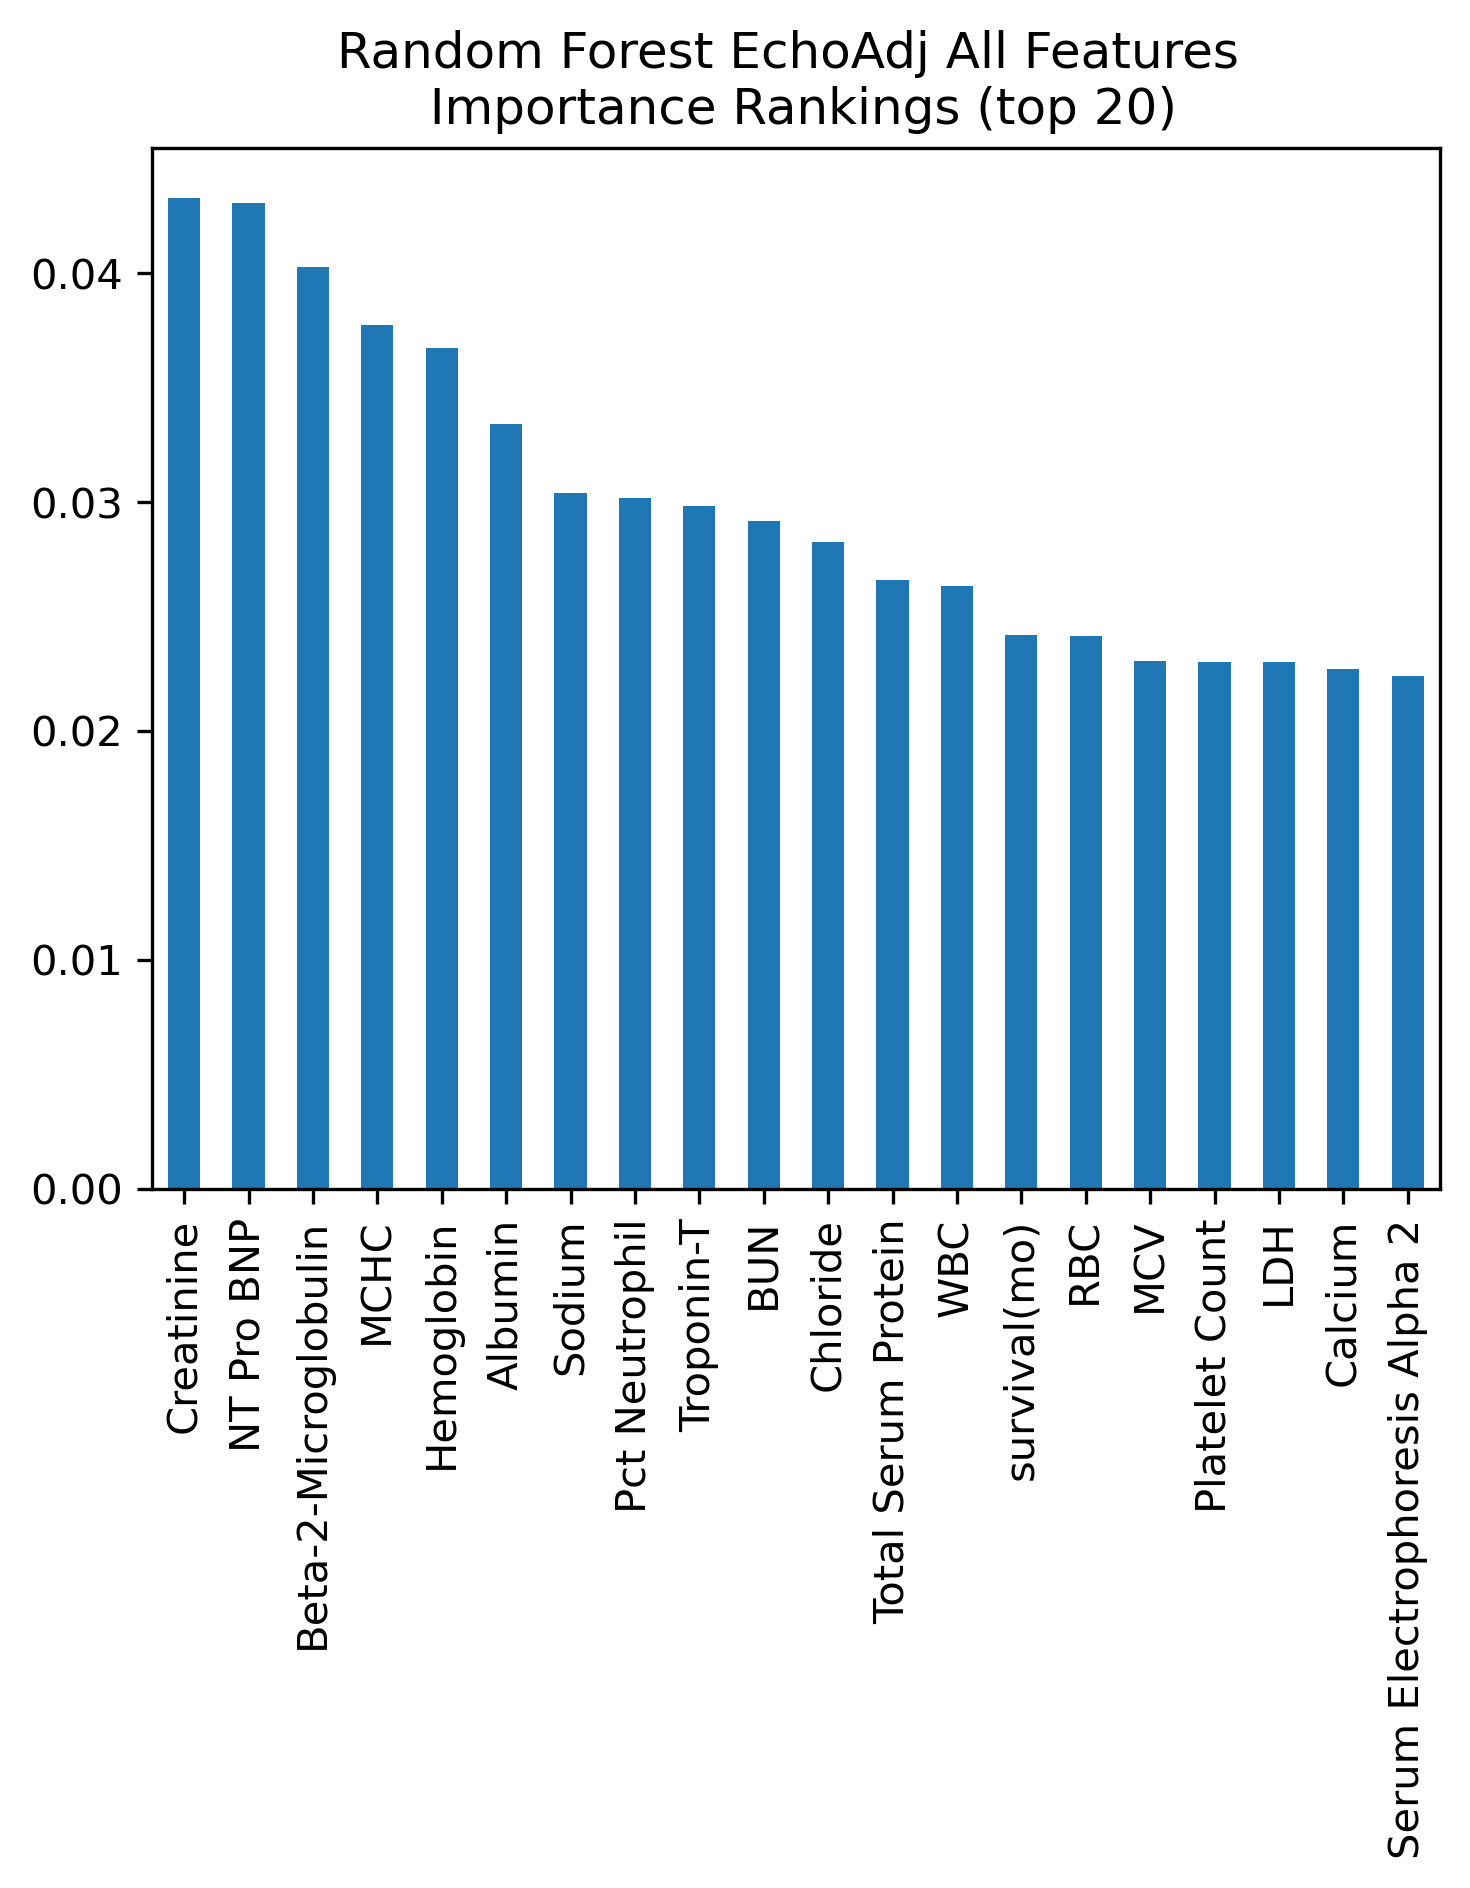

In [68]:
# Sort the importances in descending order and select the top 20 features
top_20_importances = forest_importances.sort_values(ascending=False).head(20)

# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
top_20_importances.plot.bar(ax=ax)
fig.tight_layout()
ax.set_title("Random Forest EchoAdj All Features \n Importance Rankings (top 20)")

# Show the plot
plt.show()

In [69]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))

importances_xgb = xgb_clf.feature_importances_
xgb_importances = pd.Series(importances_xgb, index= X.columns)
# fig, ax = plt.subplots()
# xgb_importances.plot.bar(ax=ax)
# ax.set_title("XGBoost All Features Importance Rankings")
# fig.tight_layout()

ROC:  0.5499999999999999
F1:  0.5


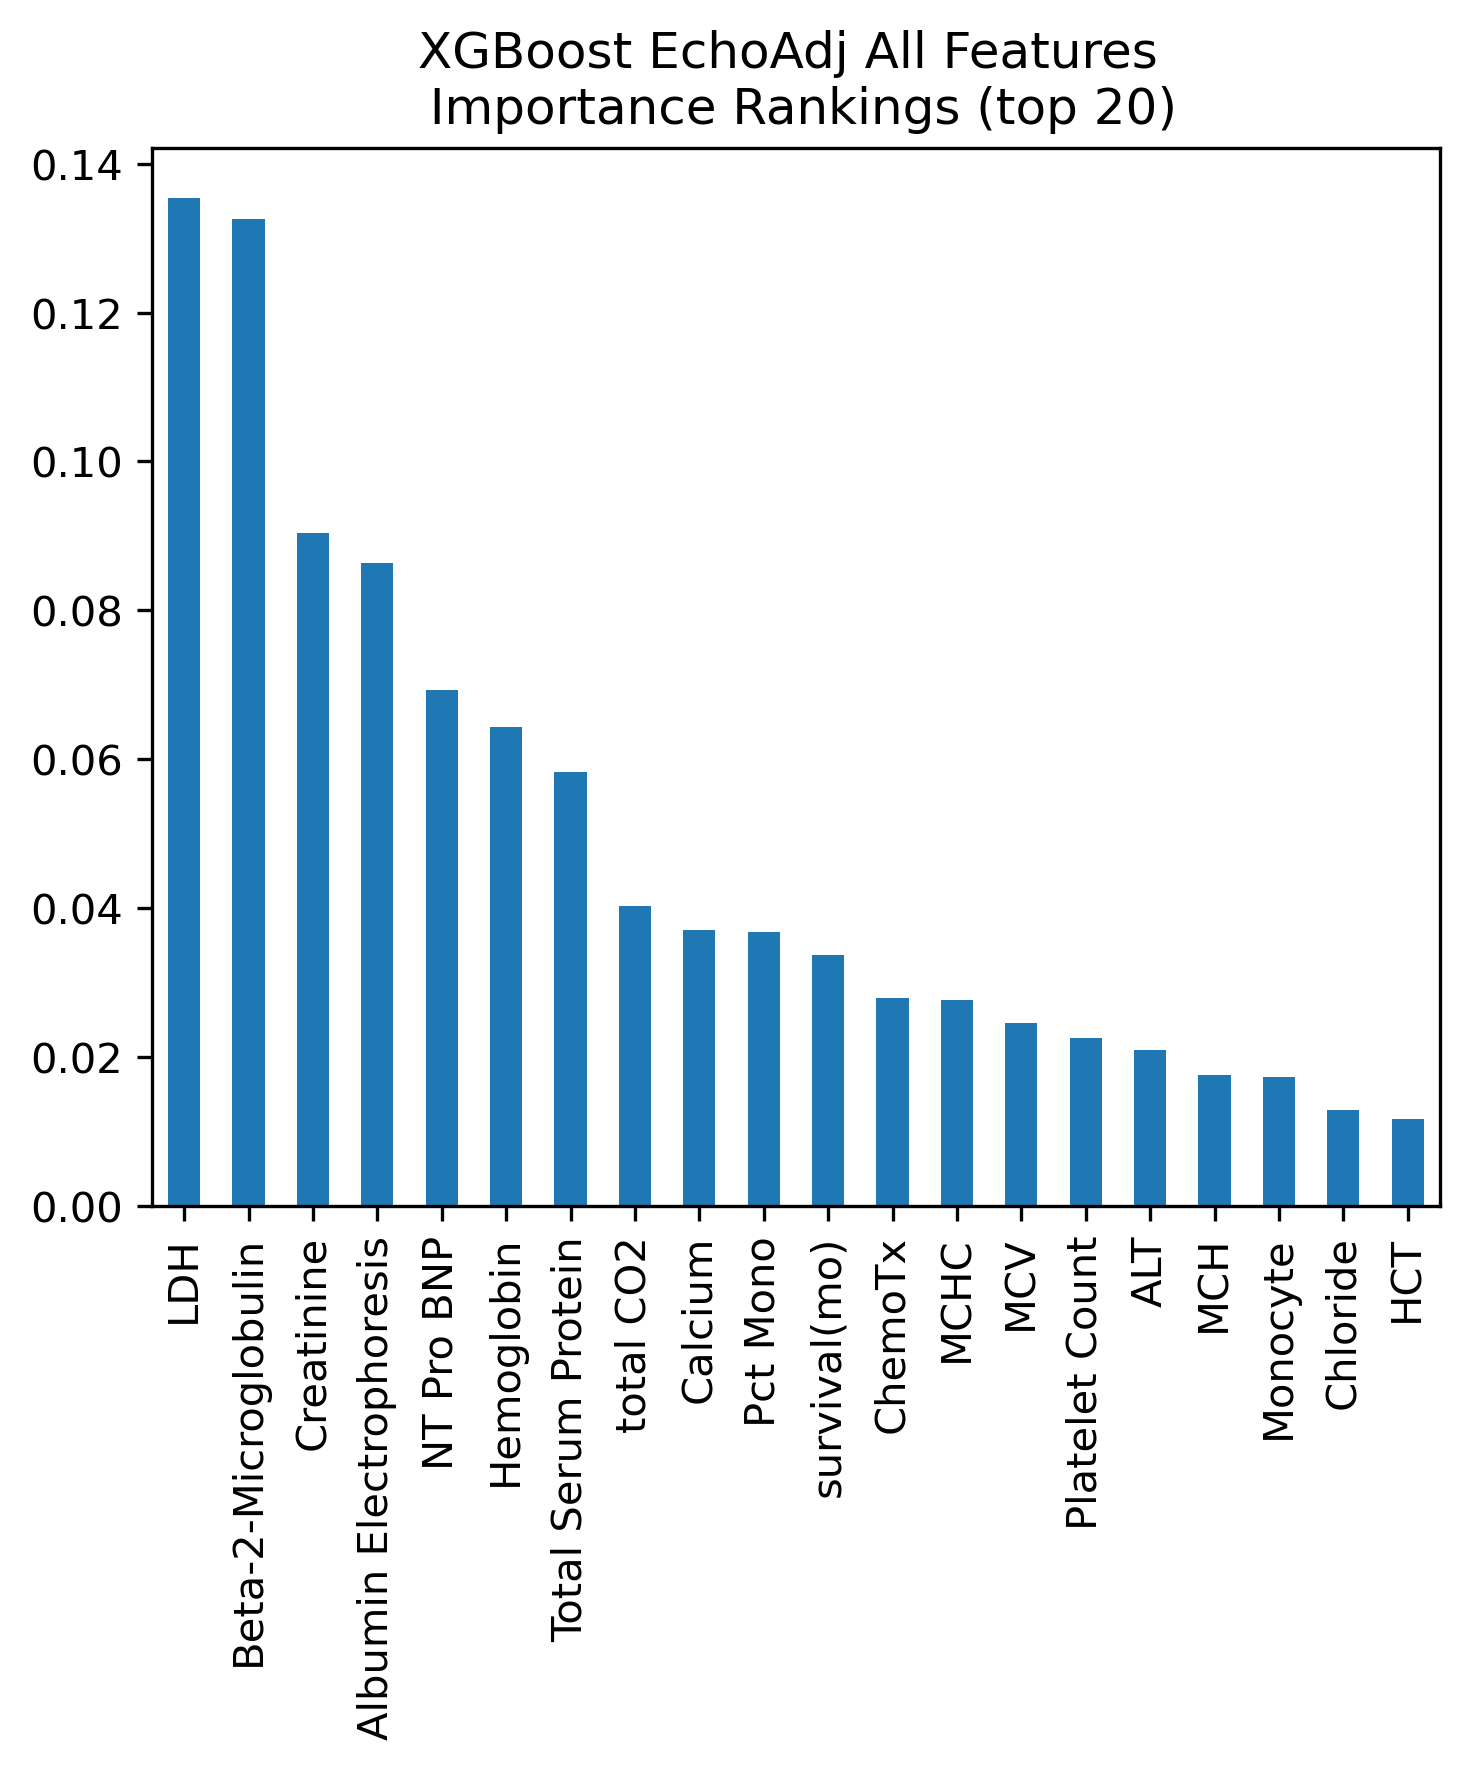

In [70]:
# Sort the importances in descending order and select the top 20 features
top_20_importances = xgb_importances.sort_values(ascending=False).head(20)

# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
top_20_importances.plot.bar(ax=ax)
ax.set_title("XGBoost EchoAdj All Features \n Importance Rankings (top 20)")
fig.tight_layout()

# Show the plot
plt.show()

In [71]:
paramsLGBM = {
    'objective': 'binary',
    'boosting_type':'gbdt',
    # 'num_leaves' : 45, 
    'learning_rate' : 0.05,
    'feature_fraction' : 0.90,
    'min_data_in_leaf': 1
}

lgb_clf = lgb.LGBMClassifier(**paramsLGBM)
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)
# lgb_clf.predict_proba(X_test)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 17, number of negative: 18
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 35, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485714 -> initscore=-0.057158
[LightGBM] [Info] 

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



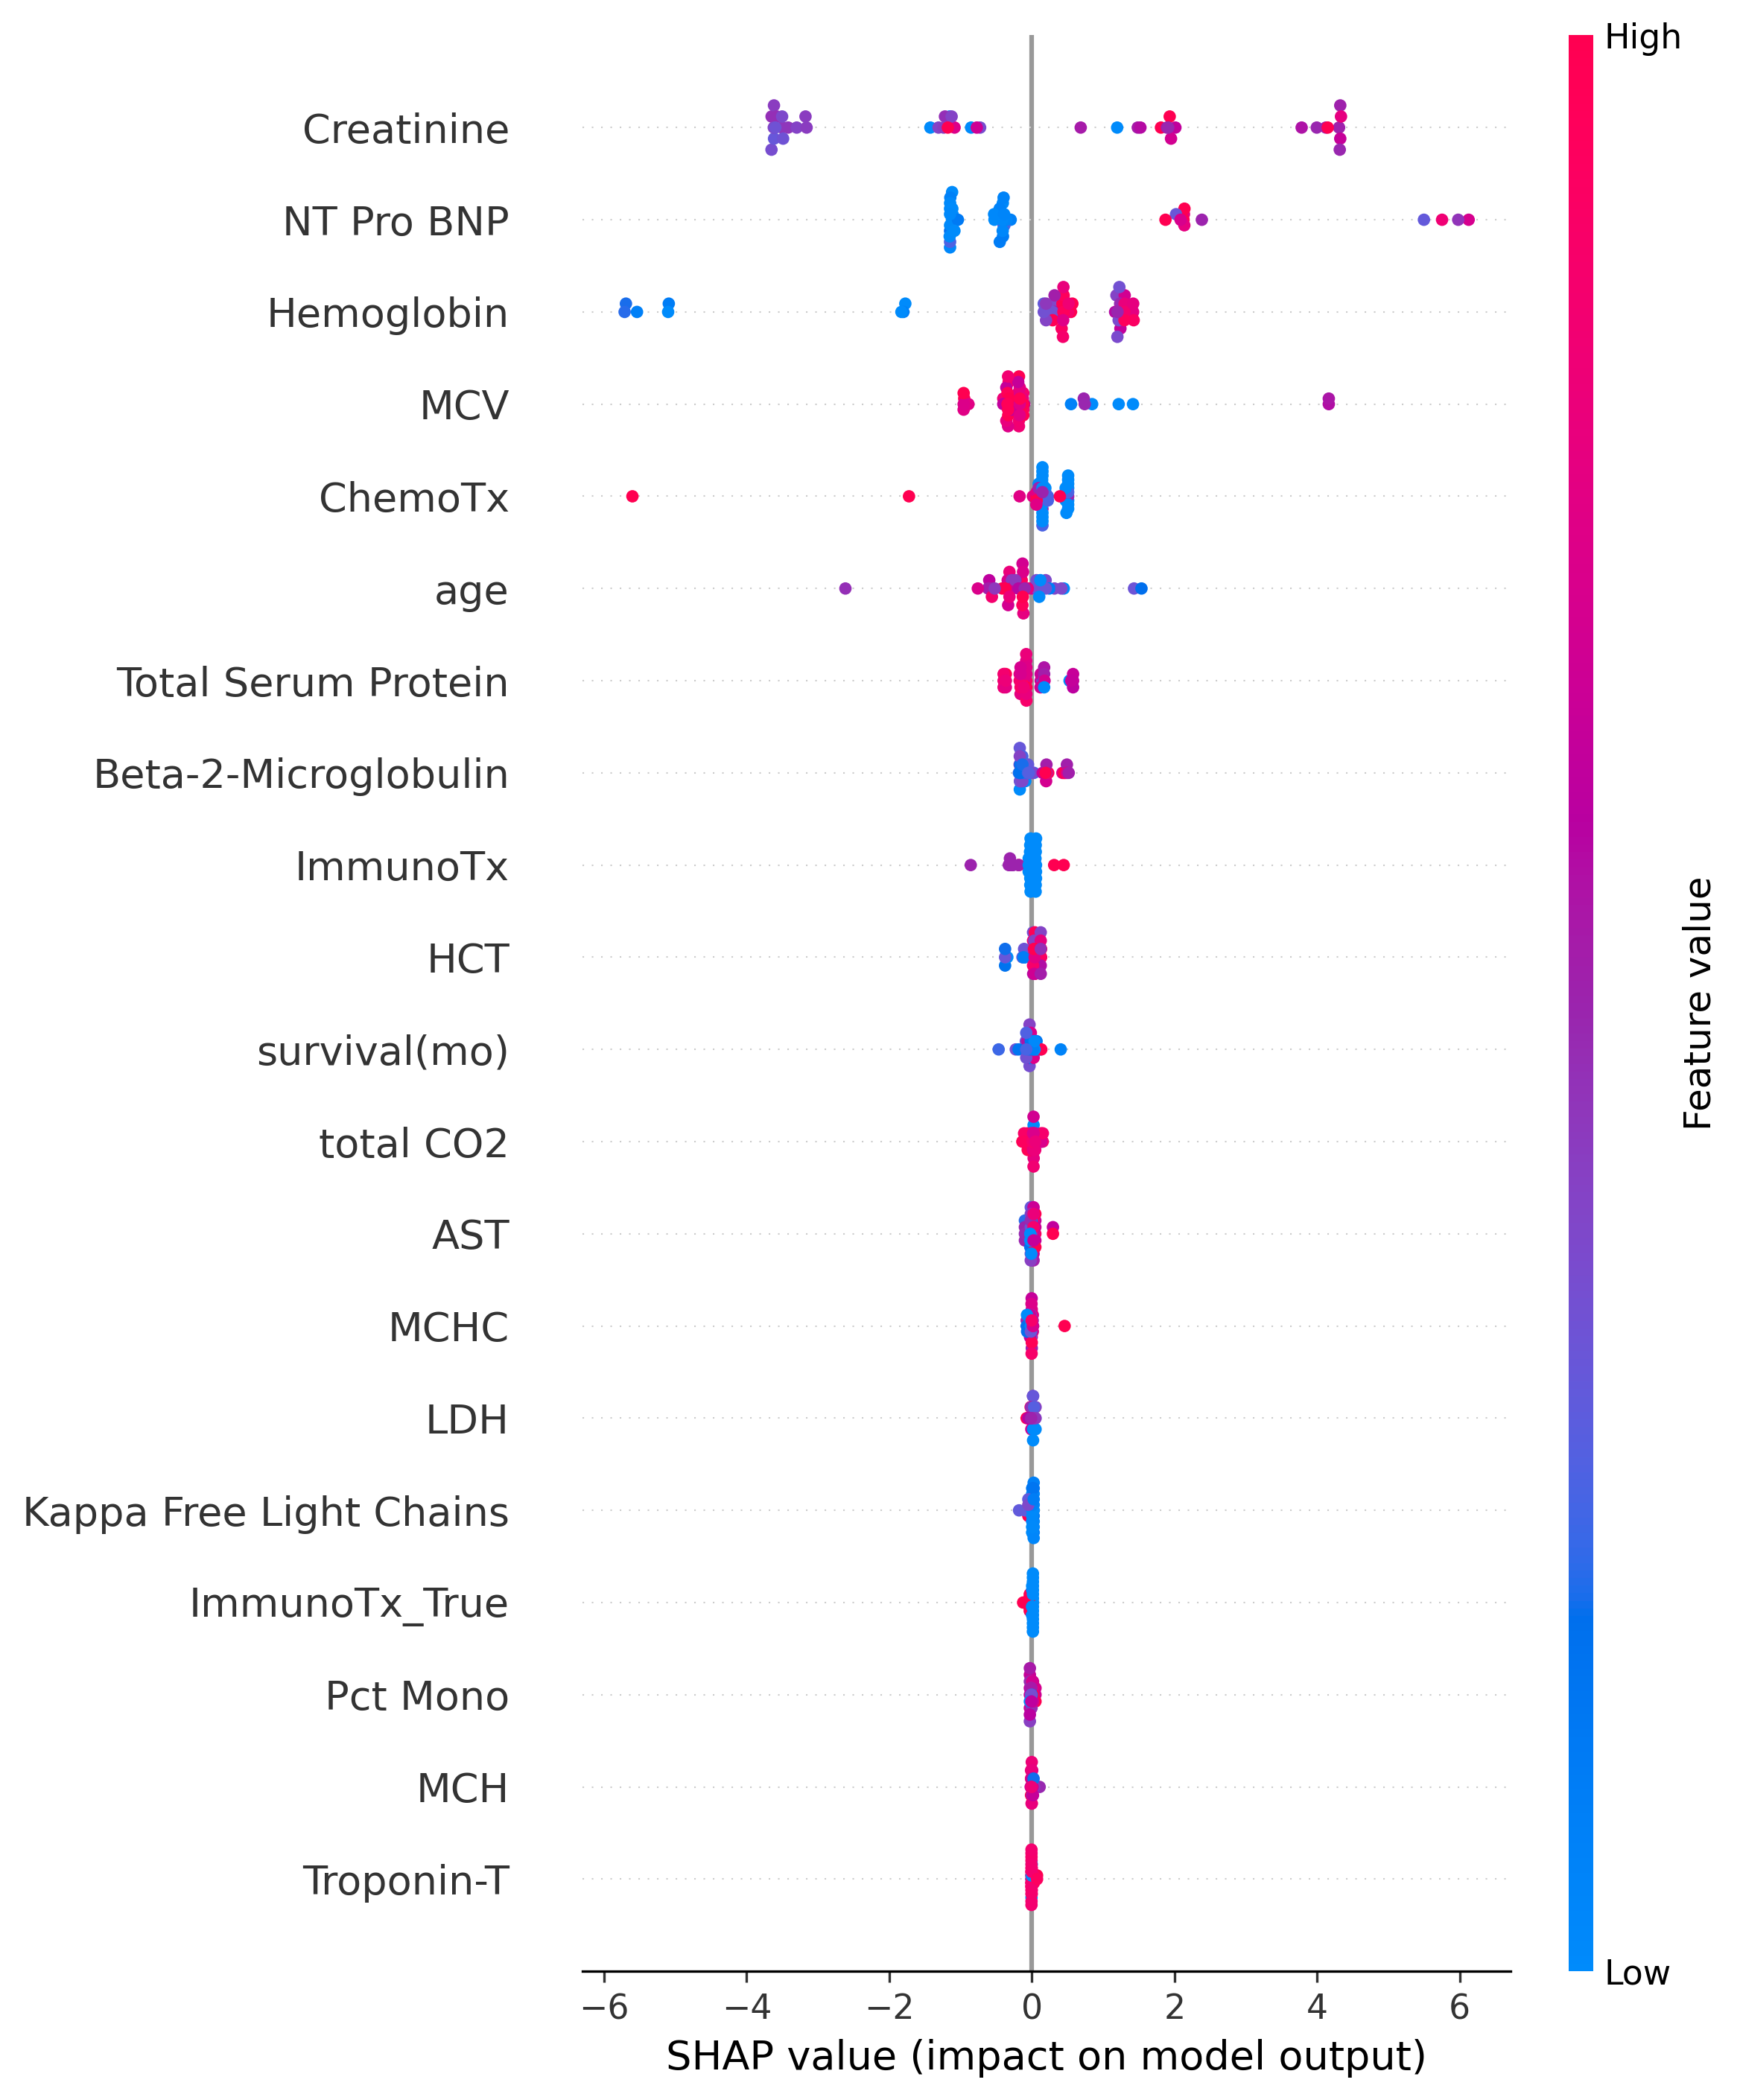

In [72]:
import shap
#borrowed from online source and edited
# create explainer
explainer = shap.TreeExplainer(lgb_clf)

#binary predictions
y_proba = lgb_clf.predict_proba(X_all)[:,1]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_all)

shap.summary_plot(shap_values, X_all, feature_names = X.columns)


# bar plot for feature importances
# shap.summary_plot(shap_values_reshaped[1], X_test, plot_type="bar")

# Show the plot
plt.show()

# feature selection

In [73]:
svm_set_ranks = []
for i in range(len(rank_weights)):
    print(f"Rank weight: {rank_weights[i]:.2f}")
    svm_set_ranks.append(svmSet(svc, cv_set,
                                score_method = score_svc().score,
                                kernel = kernelWrapper(type = kernel_type),
                                separate_feature_sets = False,
                                separate_parameters = False,
                                sparse_kernel_matrix = False))

    svm_set_ranks[i].greedy_backward_selection(parameter_grid = parameter_grid,
                                           reduction_factor = red_factor,
                                           feature_ranker = combined_rank(weight=rank_weights[i]).compute,
                                           set_for_rank = "sample")

Rank weight: 0.00
Number of Features: 54, Score: 0.672
Number of Features: 40, Score: 0.743
Number of Features: 29, Score: 0.689
Number of Features: 21, Score: 0.656
Number of Features: 15, Score: 0.644
Number of Features: 11, Score: 0.667
Number of Features: 8, Score: 0.676
Number of Features: 5, Score: 0.728
Number of Features: 3, Score: 0.738
Number of Features: 2, Score: 0.767
Number of Features: 1, Score: 0.583
Rank weight: 0.15
Number of Features: 54, Score: 0.672
Number of Features: 40, Score: 0.743
Number of Features: 29, Score: 0.678
Number of Features: 21, Score: 0.701
Number of Features: 15, Score: 0.677
Number of Features: 11, Score: 0.700
Number of Features: 8, Score: 0.689
Number of Features: 5, Score: 0.727
Number of Features: 3, Score: 0.733
Number of Features: 2, Score: 0.767
Number of Features: 1, Score: 0.583
Rank weight: 0.20
Number of Features: 54, Score: 0.672
Number of Features: 40, Score: 0.743
Number of Features: 29, Score: 0.678
Number of Features: 21, Score: 

# Performance plots

## F1 and AUC plots

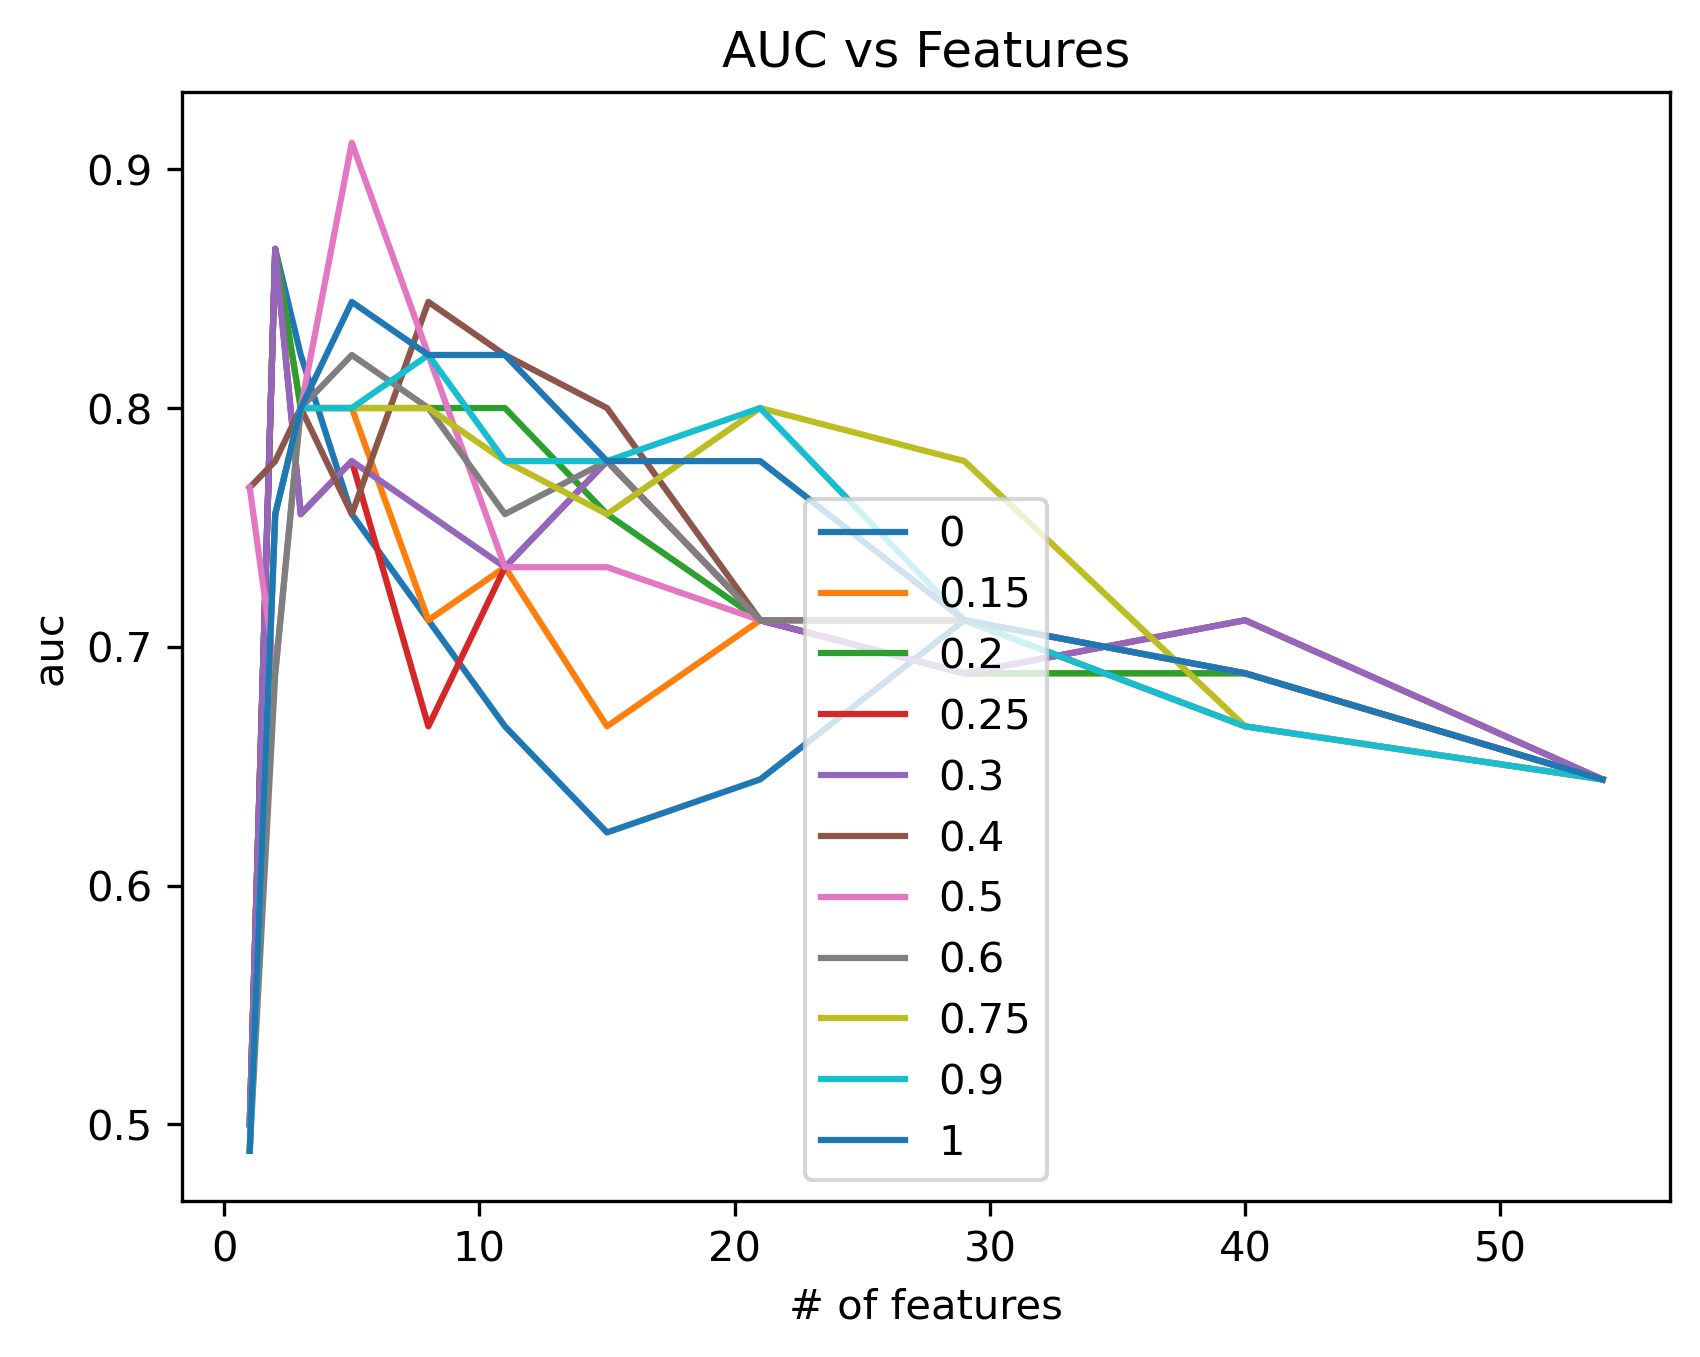

In [74]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="auc")

plt.legend(labels=rank_weights)
ax.set_title("AUC vs Features")

#saving figure
figCommon = fileName_common + "_AUC"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

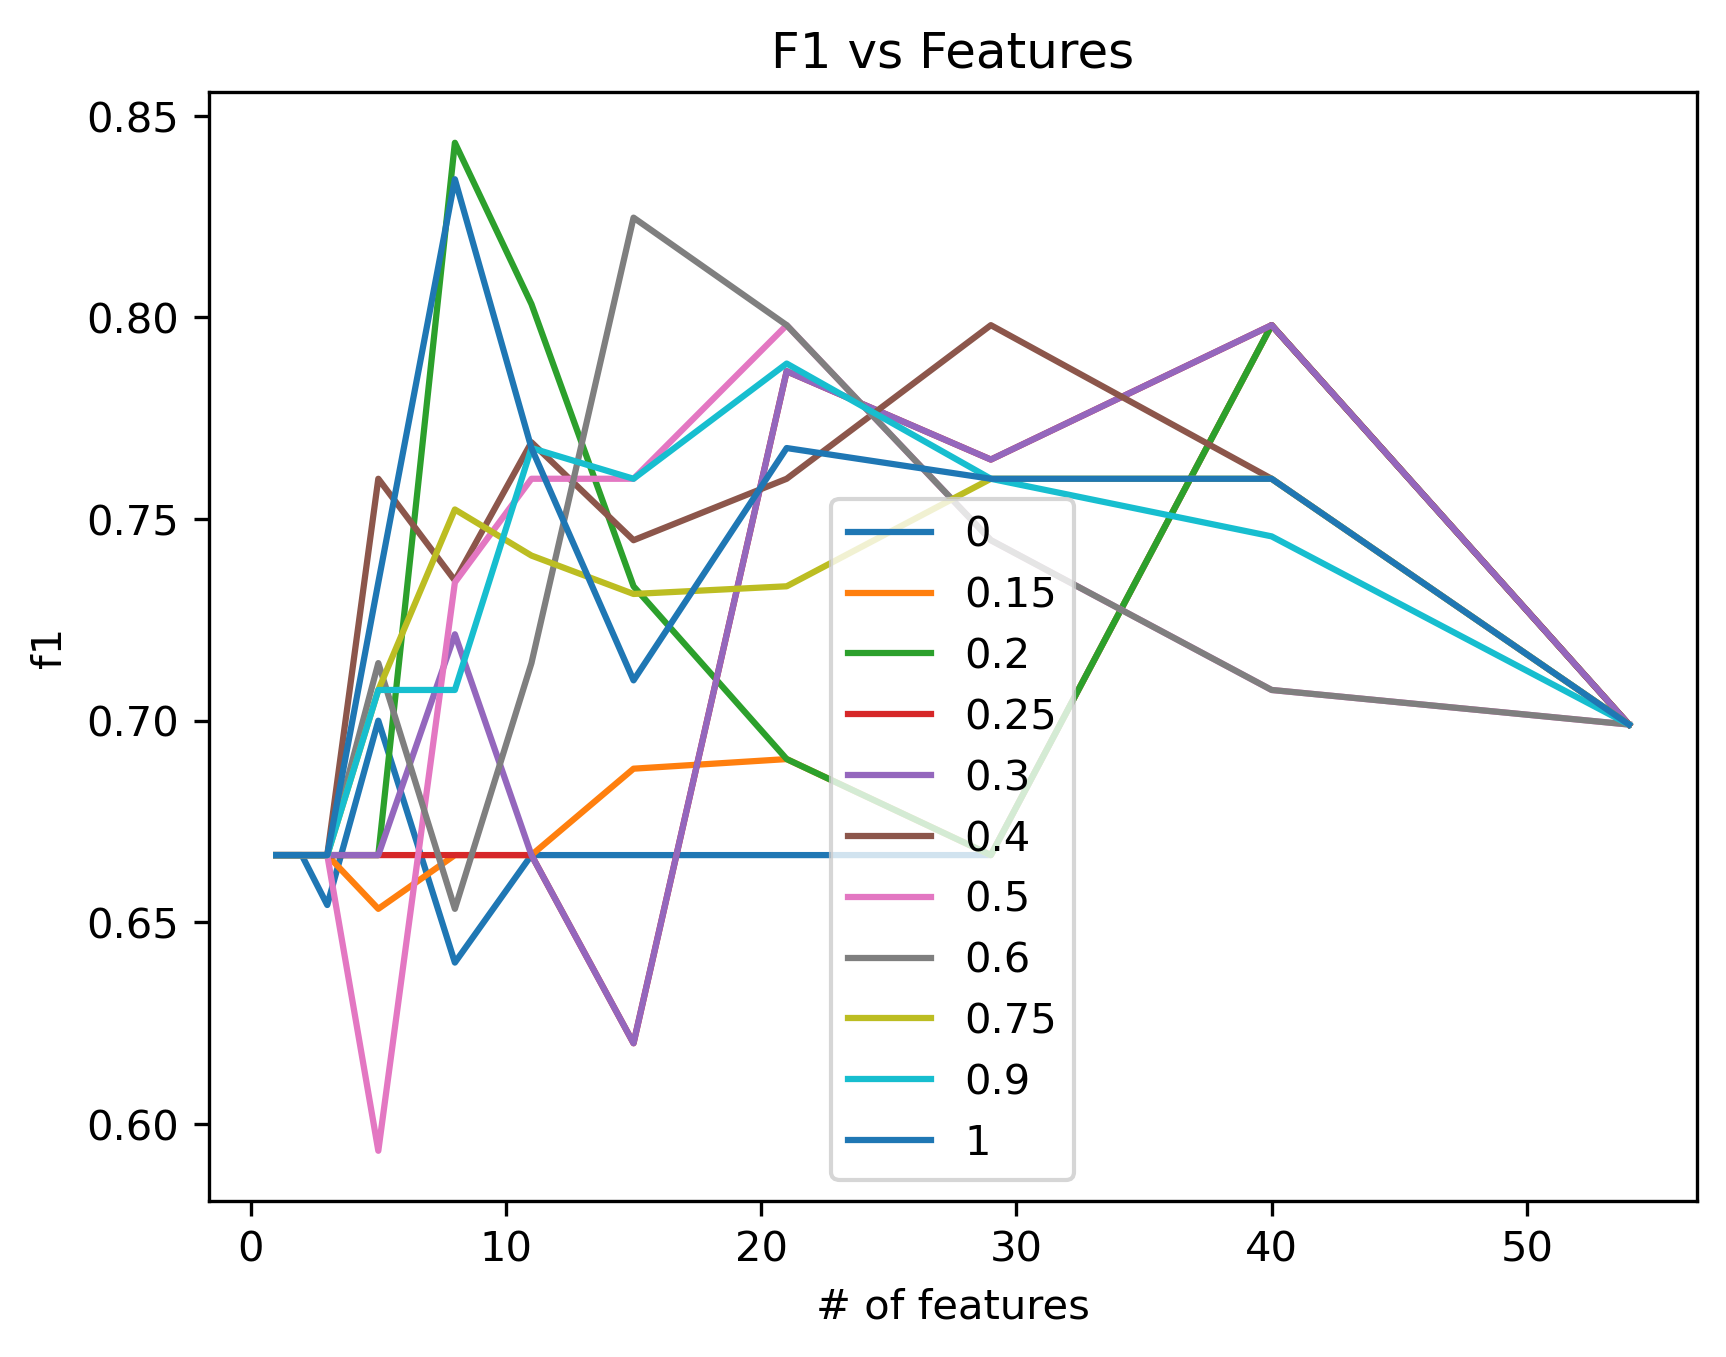

In [75]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="f1")

plt.legend(labels=rank_weights)
ax.set_title("F1 vs Features")

#saving figure
figCommon = fileName_common + "_F1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

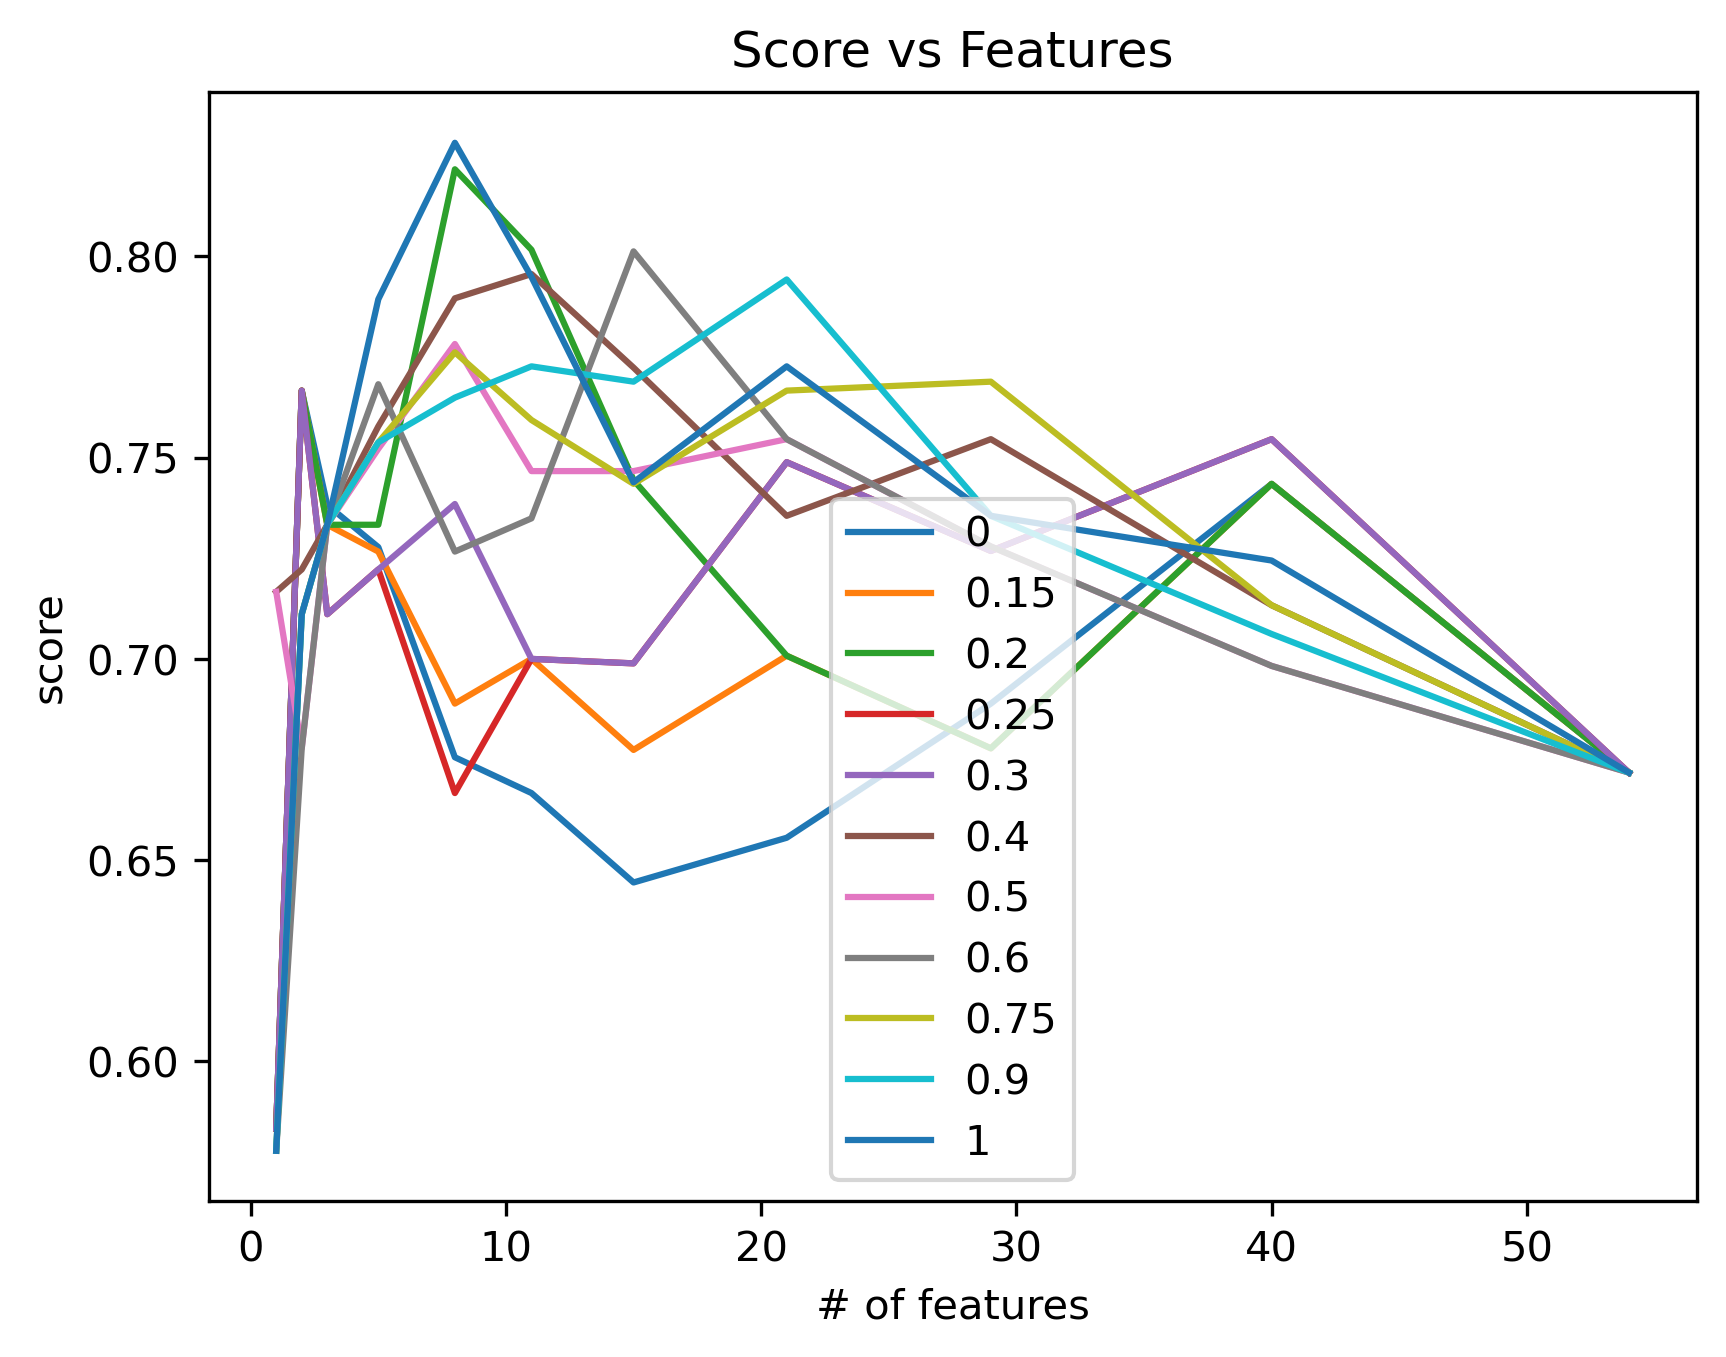

In [76]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="score")

plt.legend(labels=rank_weights)
ax.set_title("Score vs Features")

#saving figure
figCommon = fileName_common + "_Score"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

# picking best model 

In [77]:
enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score(type = "auc"))

#selected_run = 4
selected_run = enrich_score.index(max(enrich_score))

enrich_score

[0.6795664315108759,
 0.689238683127572,
 0.7097229570840682,
 0.7066078777189887,
 0.710598177542622,
 0.7227211934156378,
 0.7097427983539094,
 0.710627572016461,
 0.721820987654321,
 0.7204732510288067,
 0.7261904761904762]

In [78]:
svm_set_ranks[selected_run].performance_

{'f1': 0.8342857142857143,
 'auc': 0.8222222222222222,
 'score': 0.8282539682539684,
 'C': 0.015625,
 'num_features': 8,
 'mean_nSV': 29.0}

In [79]:
score_list = []

for i in range(len(rank_weights)):
    score_list.append(svm_set_ranks[i].performance_['score'])

maxScore = max(score_list)
topModelIndex = score_list.index(maxScore)


In [80]:
#saving the feature ranking, performance, and model evaluations to spreadsheets

for i in range(len(rank_weights)):
    #collecting the performance as a dataframe
    df_bestPerformance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index')
    outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".", "") + "_best model perf")


    df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[i].features]))
    #saving the best features
    outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".","") + "_features")




In [81]:
iterator = 1
for i in range(len(rank_weights)):
    if iterator == 1:
        #create the df_performance and collect the performance information
        df_performance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T

        #create feature list dataframe 
        df_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        iterator = iterator + 1 #to increment
    else:
        #collect the data and add it to the existing frames
        df_temp_perf = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T
        df_temp_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        #concatinate with pervious
        df_performance = pd.concat([df_performance, df_temp_perf], axis =0)
        df_features = pd.concat([df_features, df_temp_features], axis = 1)
        iterator = iterator + 1

#saving the features and performance
outputToExcel(df_data=df_performance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_best model perf")

outputToExcel(df_data=df_features, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_features")

iterator = 1
dict_blindprediction = {} #index is the weight
for i in range(len(rank_weights)):
    decision_values = svm_set_ranks[i].decision_function(X_test)
    y_pred = svm_set_ranks[i].predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn + fp)
    f1 = 2*precision*recall/(precision+recall)
    auc = roc_auc_score(y_test, decision_values)

    dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 'false neg': fn, 'true pos': tp,
                           'precision or PPV': precision, 'recall or TPR': recall, 'specificity or TNR': specificity}
    if iterator == 1:
        df_blindprediction = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        iterator = iterator +1
    else:
        df_temp_blindpred = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        df_blindprediction = pd.concat([df_blindprediction, df_temp_blindpred], axis = 0)
        iterator = iterator + 1
    # print(df_temp_blindpred)
    # dict_blindprediction[str(rank_weights[i])] = df_temp_blindpred

# df_blindprediction = pd.DataFrame.from_dict(dict_blindprediction, orient= 'index')
outputToExcel(df_data=df_blindprediction, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_blindprediction")


In [82]:
df_blindprediction

f1   auc  true neg  false pos  false neg  true pos  \
0     0.615385  0.75       0.0        5.0        0.0       4.0   
0.15  0.615385  0.75       0.0        5.0        0.0       4.0   
0.2   0.750000  0.90       4.0        1.0        1.0       3.0   
0.25  0.615385  0.75       0.0        5.0        0.0       4.0   
0.3   0.615385  0.75       0.0        5.0        0.0       4.0   
0.4   0.750000  0.85       4.0        1.0        1.0       3.0   
0.5   0.571429  0.85       4.0        1.0        2.0       2.0   
0.6   0.666667  0.90       5.0        0.0        2.0       2.0   
0.75  0.800000  0.80       3.0        2.0        0.0       4.0   
0.9   0.750000  0.85       4.0        1.0        1.0       3.0   
1     0.571429  0.80       4.0        1.0        2.0       2.0   

      precision or PPV  recall or TPR  specificity or TNR  
0             0.444444           1.00                 0.0  
0.15          0.444444           1.00                 0.0  
0.2           0.750000           0.75                 0.8  
0.25          0.444444           1.00                 0.0  
0.3           0.444444           1.00                 0.0  
0.4           0.750000           0.75                 0.8  
0.5           0.666667           0.50                 0.8  
0.6           1.000000           0.50                 1.0  
0.75          0.666667           1.00                 0.6  
0.9           0.750000           0.75                 0.8  
1             0.666667           0.50                 0.8

In [83]:
df_performance

f1       auc     score         C  num_features  mean_nSV
0     0.666667  0.866667  0.766667  0.003906           2.0      29.0
0.15  0.666667  0.866667  0.766667  0.003906           2.0      29.0
0.2   0.843333  0.800000  0.821667  0.250000           8.0      23.0
0.25  0.666667  0.866667  0.766667  0.003906           2.0      29.0
0.3   0.666667  0.866667  0.766667  0.003906           2.0      29.0
0.4   0.769048  0.822222  0.795635  1.000000          11.0      19.0
0.5   0.734286  0.822222  0.778254  0.031250           8.0      28.6
0.6   0.824762  0.777778  0.801270  0.015625          15.0      28.8
0.75  0.752381  0.800000  0.776190  0.015625           8.0      29.0
0.9   0.788571  0.800000  0.794286  0.007812          21.0      29.0
1     0.834286  0.822222  0.828254  0.015625           8.0      29.0

In [84]:
df_features

0        0.15                  0.2        0.25         0.3  \
0          age         age                  age         age         age   
1   NT Pro BNP  NT Pro BNP        HematologicTx  NT Pro BNP  NT Pro BNP   
2          NaN         NaN   HematologicTx_True         NaN         NaN   
3          NaN         NaN              Albumin         NaN         NaN   
4          NaN         NaN                  BUN         NaN         NaN   
5          NaN         NaN                  LDH         NaN         NaN   
6          NaN         NaN  Total Serum Protein         NaN         NaN   
7          NaN         NaN           NT Pro BNP         NaN         NaN   
8          NaN         NaN                  NaN         NaN         NaN   
9          NaN         NaN                  NaN         NaN         NaN   
10         NaN         NaN                  NaN         NaN         NaN   
11         NaN         NaN                  NaN         NaN         NaN   
12         NaN         NaN                  NaN         NaN         NaN   
13         NaN         NaN                  NaN         NaN         NaN   
14         NaN         NaN                  NaN         NaN         NaN   
15         NaN         NaN                  NaN         NaN         NaN   
16         NaN         NaN                  NaN         NaN         NaN   
17         NaN         NaN                  NaN         NaN         NaN   
18         NaN         NaN                  NaN         NaN         NaN   
19         NaN         NaN                  NaN         NaN         NaN   
20         NaN         NaN                  NaN         NaN         NaN   

                     0.4                            0.5  \
0                    age                            age   
1           survival(mo)                   ChemoTx_True   
2           ChemoTx_True                        Albumin   
3       RadiationTx_True                            BUN   
4                Albumin           Beta-2-Microglobulin   
5                    BUN                            LDH   
6   Beta-2-Microglobulin  Serum Electrophoresis Alpha 1   
7     Immature Gran Auto                     NT Pro BNP   
8                    LDH                            NaN   
9         Pct Neutrophil                            NaN   
10            NT Pro BNP                            NaN   
11                   NaN                            NaN   
12                   NaN                            NaN   
13                   NaN                            NaN   
14                   NaN                            NaN   
15                   NaN                            NaN   
16                   NaN                            NaN   
17                   NaN                            NaN   
18                   NaN                            NaN   
19                   NaN                            NaN   
20                   NaN                            NaN   

                              0.6                           0.75  \
0                             age                   ChemoTx_True   
1                    ChemoTx_True                            BUN   
2                         Albumin           Beta-2-Microglobulin   
3                             BUN                     Neutrophil   
4            Beta-2-Microglobulin                 Platelet Count   
5                        Chloride  Serum Electrophoresis Alpha 1   
6                      Creatinine                     NT Pro BNP   
7              Immature Gran Auto                     Troponin-T   
8                             LDH                            NaN   
9                  Pct Neutrophil                            NaN   
10                 Platelet Count                            NaN   
11  Serum Electrophoresis Alpha 1                            NaN   
12  Serum Electrophoresis Alpha 2                            NaN   
13                     NT Pro BNP                            NaN   
14                     Troponin-T          

## pair plots

In [85]:
X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values

array(['Serum Electrophoresis Alpha 1', 'Beta-2-Microglobulin',
       'NT Pro BNP', 'Creatinine', 'BUN', 'Troponin-T',
       'Serum Electrophoresis Alpha 2',
       'Kappa/Lambda Free Light Chain Ratio'], dtype=object)

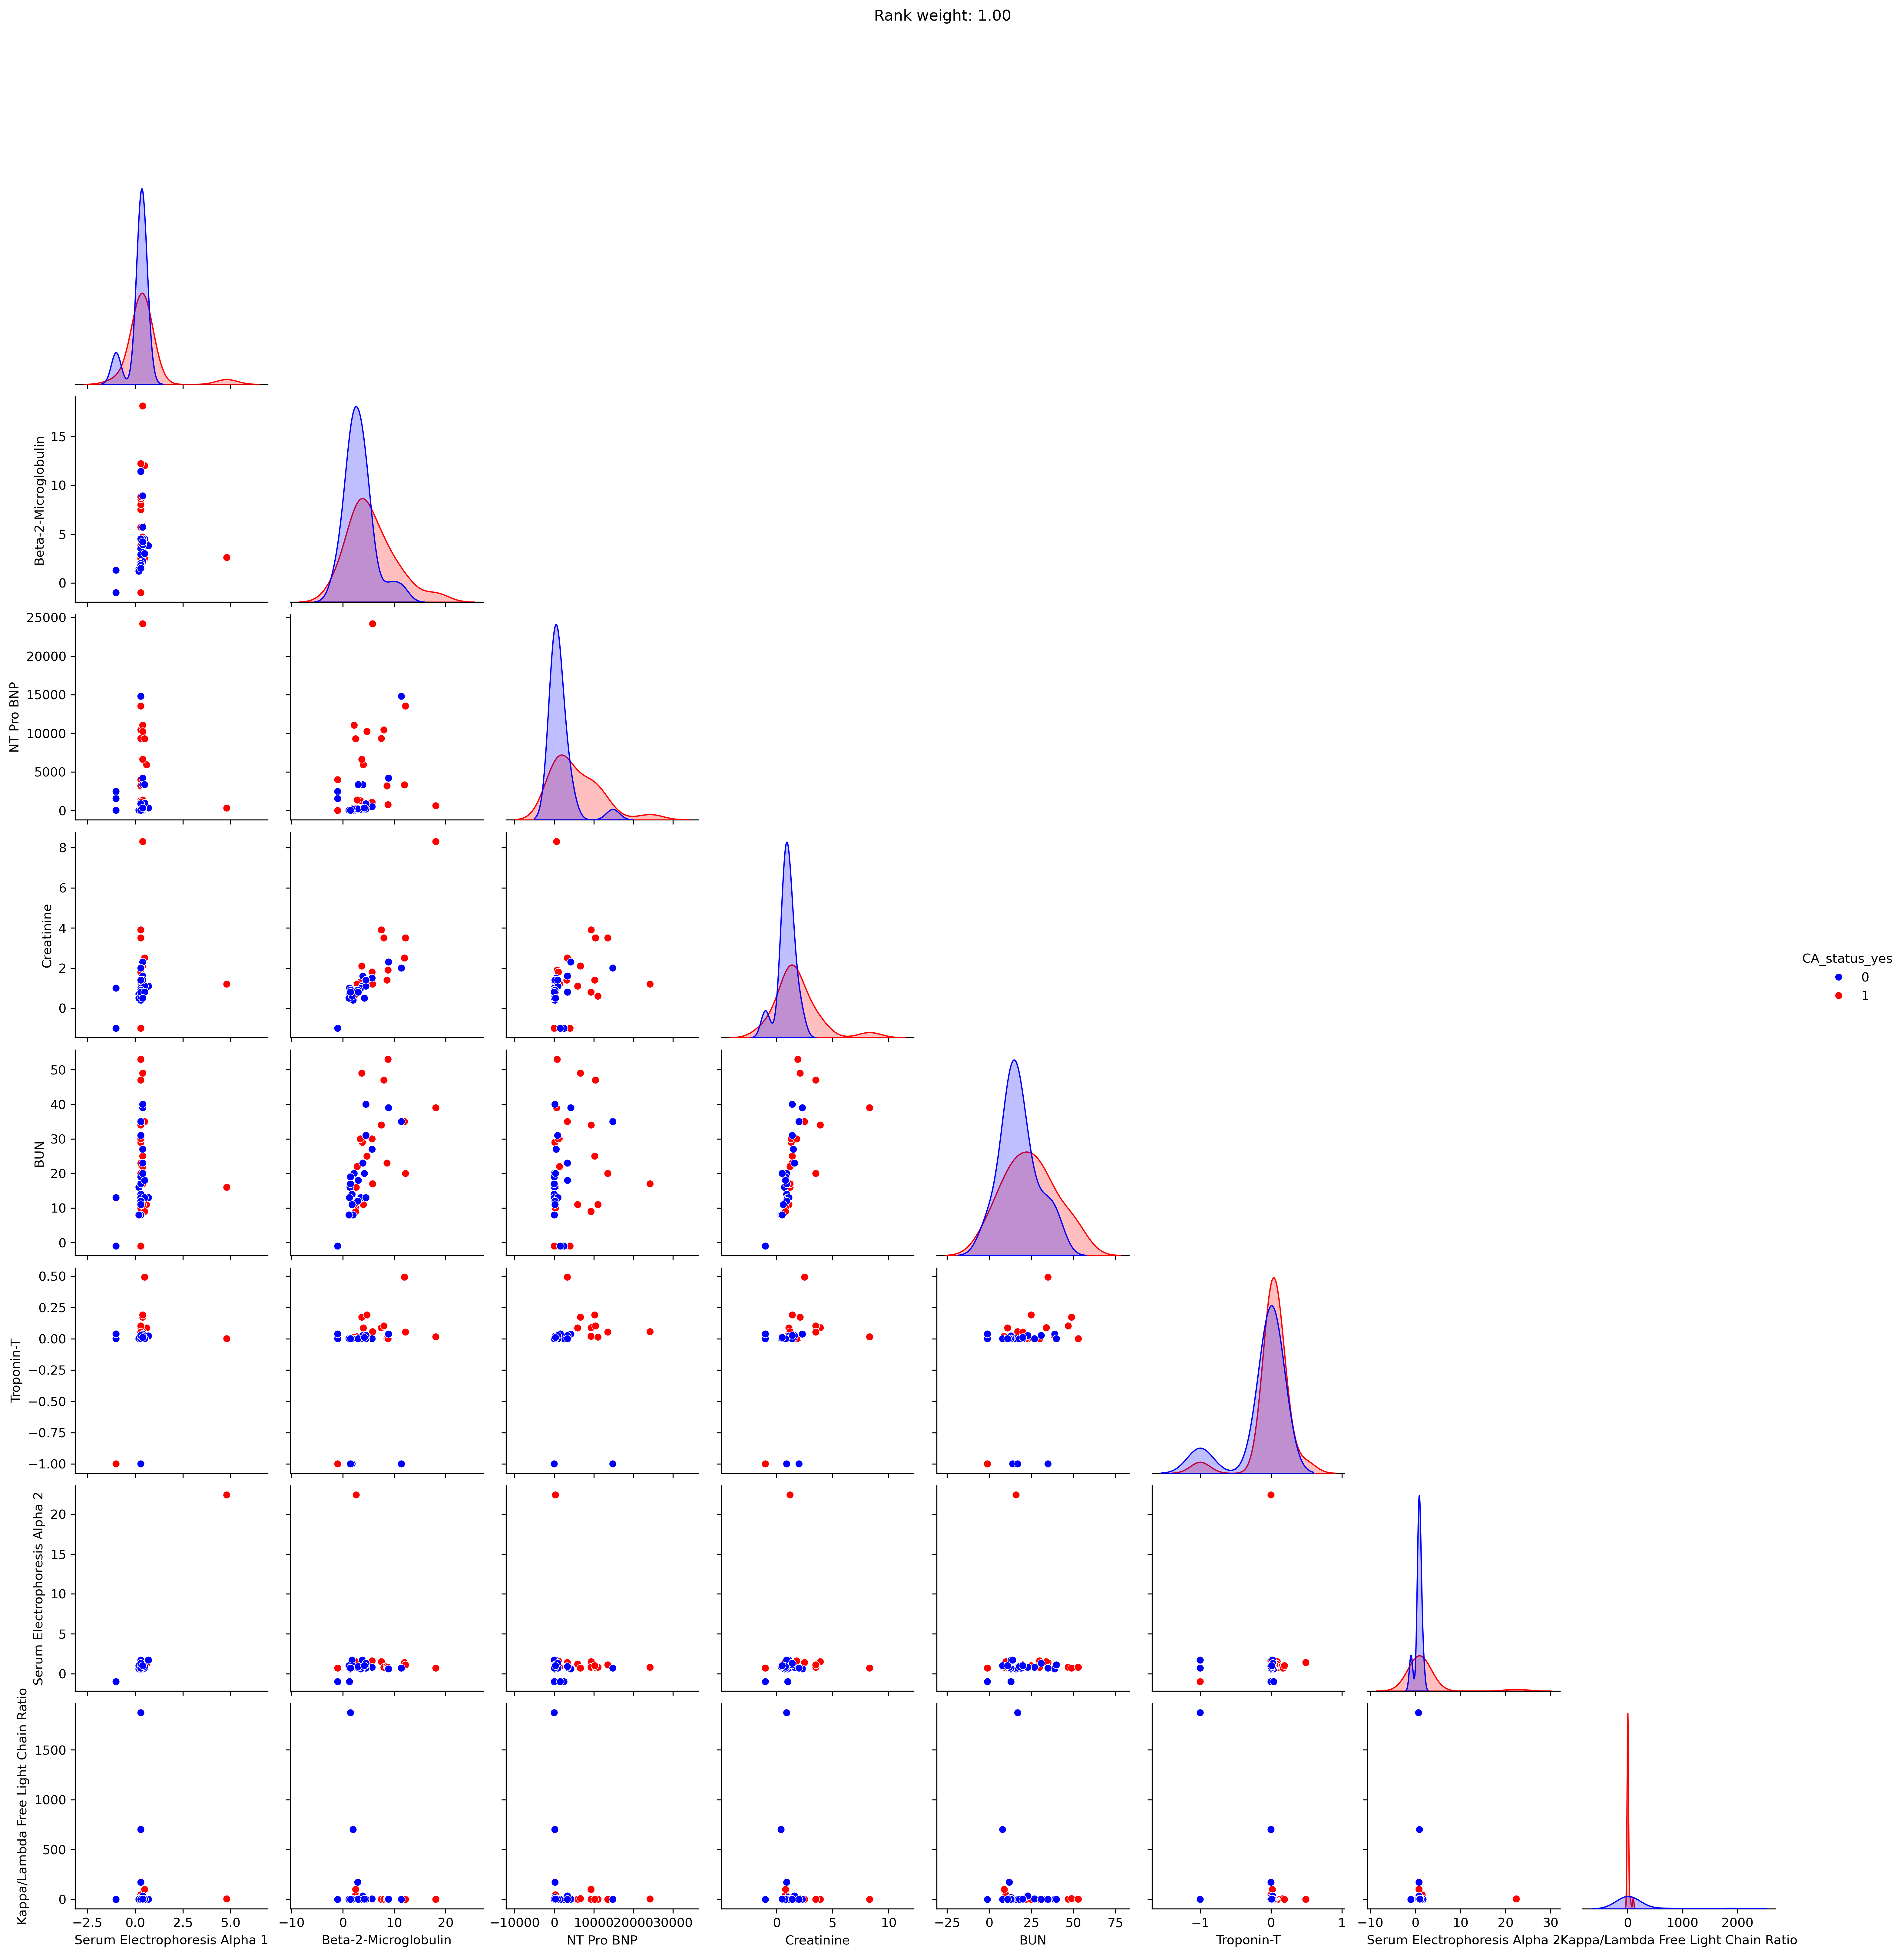

In [86]:
import plotly.express as px
from seaborn import pairplot, clustermap, load_dataset
# fig, ax = plt.subplots()

palette = {np.int64(1) :'red', np.int64(0): 'blue'} #our data is of int64

# selected_model = 0
top_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values
fig = pairplot(dataTable[np.append(top_features, y_column_Classification)],
         hue=y_column_Classification, corner=True, palette=palette)
fig.fig.suptitle(f"Rank weight: {rank_weights[selected_run]:.2f}", y=1.08)

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_pairplot"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

## 3D scatter

In [87]:
top3_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:3]].values
fig = px.scatter_3d(dataTable, x=top3_features[0], y=top3_features[1], z=top3_features[2],
          color=y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

## integrated gradients attribution

In [88]:
IG = svm_set_ranks[selected_run].integrated_gradient(X_all)
IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

features = svm_set_ranks[selected_run].features
IG_X = pd.DataFrame(X_all[:,features],columns = IGtable.columns)
#IG_X = X.iloc[:,features]
N = len(IGtable)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma/mistic/utility.py:223: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



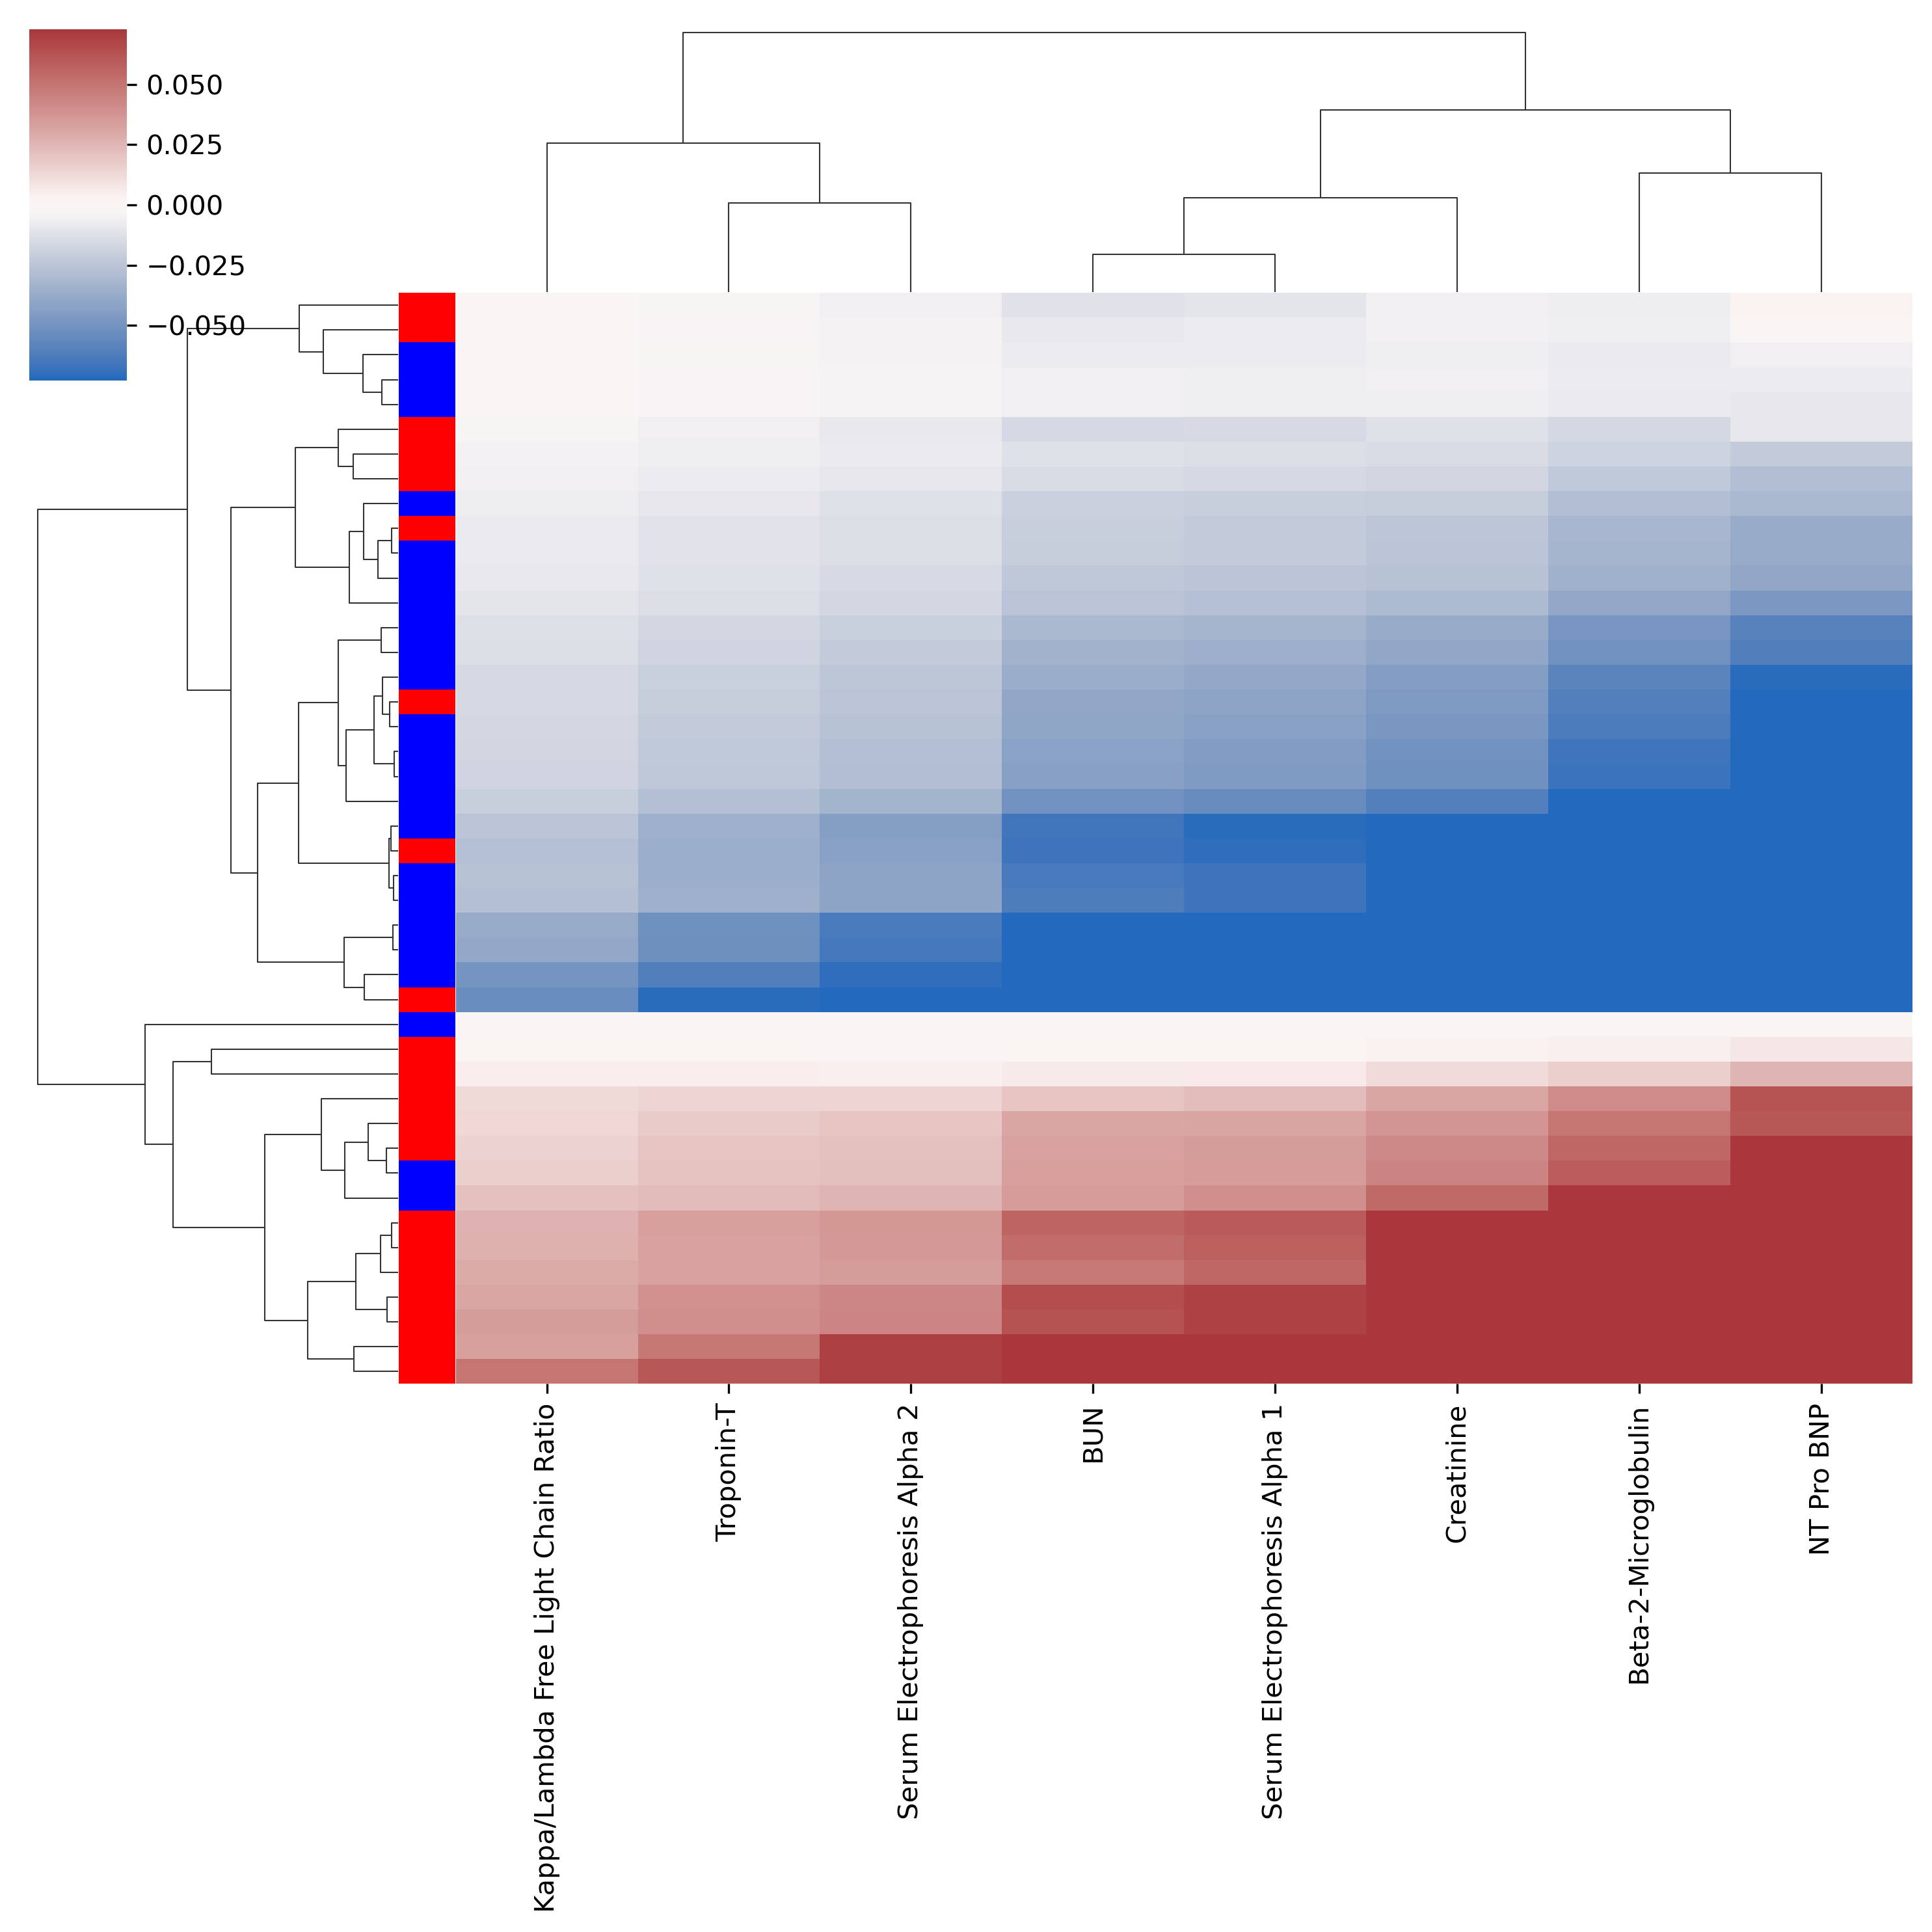

In [89]:
from seaborn import pairplot, clustermap, load_dataset
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

distMatCol = perDiff(IGtable)
hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

tr_IGtable = IGtable.transpose()
distMatRow = perDiff(tr_IGtable)
hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

#fig, ax = plt.subplots()
fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-color_val, vmax=color_val,
           row_linkage=hcRow, col_linkage=hcCol, 
           row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_all])

In [90]:
X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values

array(['Serum Electrophoresis Alpha 1', 'Beta-2-Microglobulin',
       'NT Pro BNP', 'Creatinine', 'BUN', 'Troponin-T',
       'Serum Electrophoresis Alpha 2',
       'Kappa/Lambda Free Light Chain Ratio'], dtype=object)

In [91]:
import plotly.graph_objects as go
import plotly.express as px

nbins = 10
scale = 0.1
n_features = len(X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
spacing = 2
min_max_IG = 2.5

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=1000,
    height=600,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)
 
fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    range = [-min_max_IG,min_max_IG]
    )
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    range = [-spacing, spacing*n_features + spacing]
)
 
feature_rank = np.argsort(np.sum(abs(IG),axis=0))
feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

y_val = 1
bin_ids = list(range(nbins))
for f in feature_order:
    bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
    ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
    x_vals = []
    y_vals = []
    f_vals = []
    for bin in bin_ids:
        x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
        n_pts = len(x_bin_vals)
        if n_pts > 0:
            x_vals = x_vals + x_bin_vals
            y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
            f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
    fig.add_trace(go.Scatter(
        x = x_vals, 
        y = y_vals,
        mode = 'markers',
        marker = dict(size=12,
                      color = f_vals,
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += spacing
 
 
fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 1)
fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
                 ticktext=IGtable.columns[feature_order])
 
fig.show()

In [92]:
nbins = 10
scale = 0.1
n_features = len(X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
spacing = 2
min_max_IG = 2.5

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=1000,
    height=2000,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)
 
fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    range = [-min_max_IG,min_max_IG]
    )
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    range = [-spacing, spacing*n_features + spacing]
)
 
feature_rank = np.argsort(np.sum(abs(IG),axis=0))
feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

y_val = 1
bin_ids = list(range(nbins))
for f in feature_order:
    bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
    ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
    x_vals = []
    y_vals = []
    f_vals = []
    for bin in bin_ids:
        x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
        n_pts = len(x_bin_vals)
        if n_pts > 0:
            x_vals = x_vals + x_bin_vals
            y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
            f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
    fig.add_trace(go.Scatter(
        x = x_vals, 
        y = y_vals,
        mode = 'markers',
        marker = dict(size=12,
                      color = f_vals,
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += spacing
 
 
fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 1)
fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
                 ticktext=IGtable.columns[feature_order])
 
fig.show()

In [93]:
feat_1 = IGtable.columns[feature_order[6]]
feat_2 = IGtable.columns[feature_order[5]]

fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
    font=dict(size=20)
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 1)

fig.show()

In [94]:
feat_1 = IGtable.columns[feature_order[5]]
feat_2 = IGtable.columns[feature_order[6]]

fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
    font=dict(size=20)
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 1)

fig.show()

# sensitivity and specificity 

In [95]:
decision_values = svm_set_ranks[selected_run].decision_function(X_test)
y_pred = svm_set_ranks[selected_run].predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

print("True Negative: ", tn)
print("false positive: ", fp)
print("false negative: ", fn)
print("true positive: ", tp)
print("true positive rate or recall/sensitivity: ", recall)
print("positive predictive value or precision: ", precision)
print("specificity or true negatie rate: ", specificity)
print("auc: ", auc)
print("f1 score: ", f1)

True Negative:  4
false positive:  1
false negative:  2
true positive:  2
true positive rate or recall/sensitivity:  0.5
positive predictive value or precision:  0.6666666666666666
specificity or true negatie rate:  0.8
auc:  0.8
f1 score:  0.5714285714285715


# testing alt models on best feature list

In [96]:
X_all_trim = X_all[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
X_train_trim = X_train[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
X_test_trim = X_test[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
#making the dataset only include the features from the best performing model in SVM

In [97]:
cv_set_trim = cvSet(X = X_train_trim, y = y_train.values)
cv_set_trim.classification(num_sets = numb_sets)

ROC:  0.8
F1:  0.8


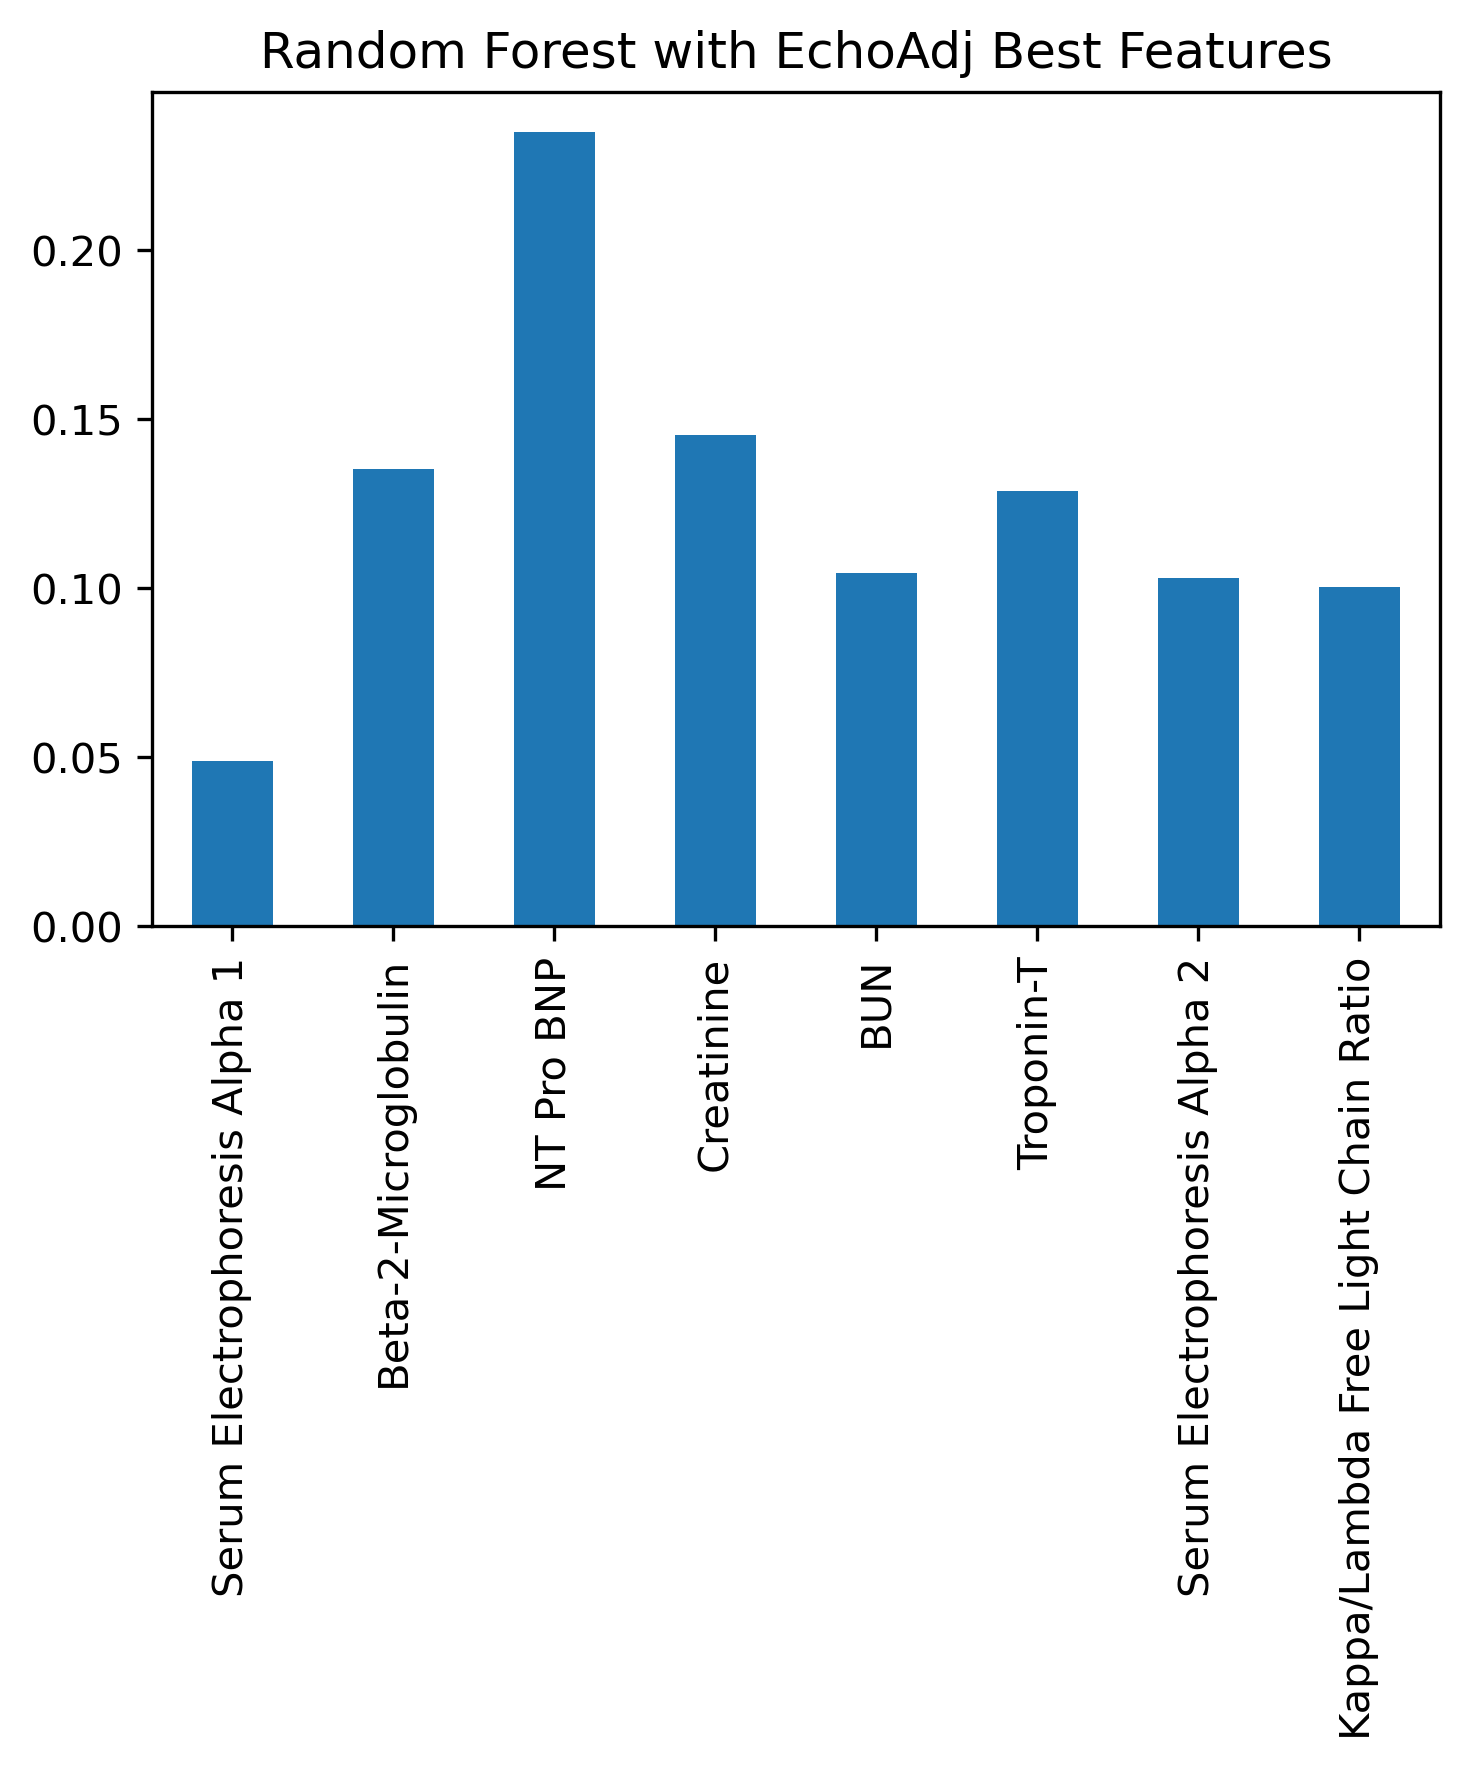

In [98]:
rnd_clf = RandomForestClassifier(random_state=0)
rnd_clf.fit(X_train_trim, y_train)
y_pred = rnd_clf.predict(X_test_trim)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
fig, ax = plt.subplots(figsize = (5,6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Random Forest with EchoAdj Best Features")
fig.tight_layout()

ROC:  0.8
F1:  0.8


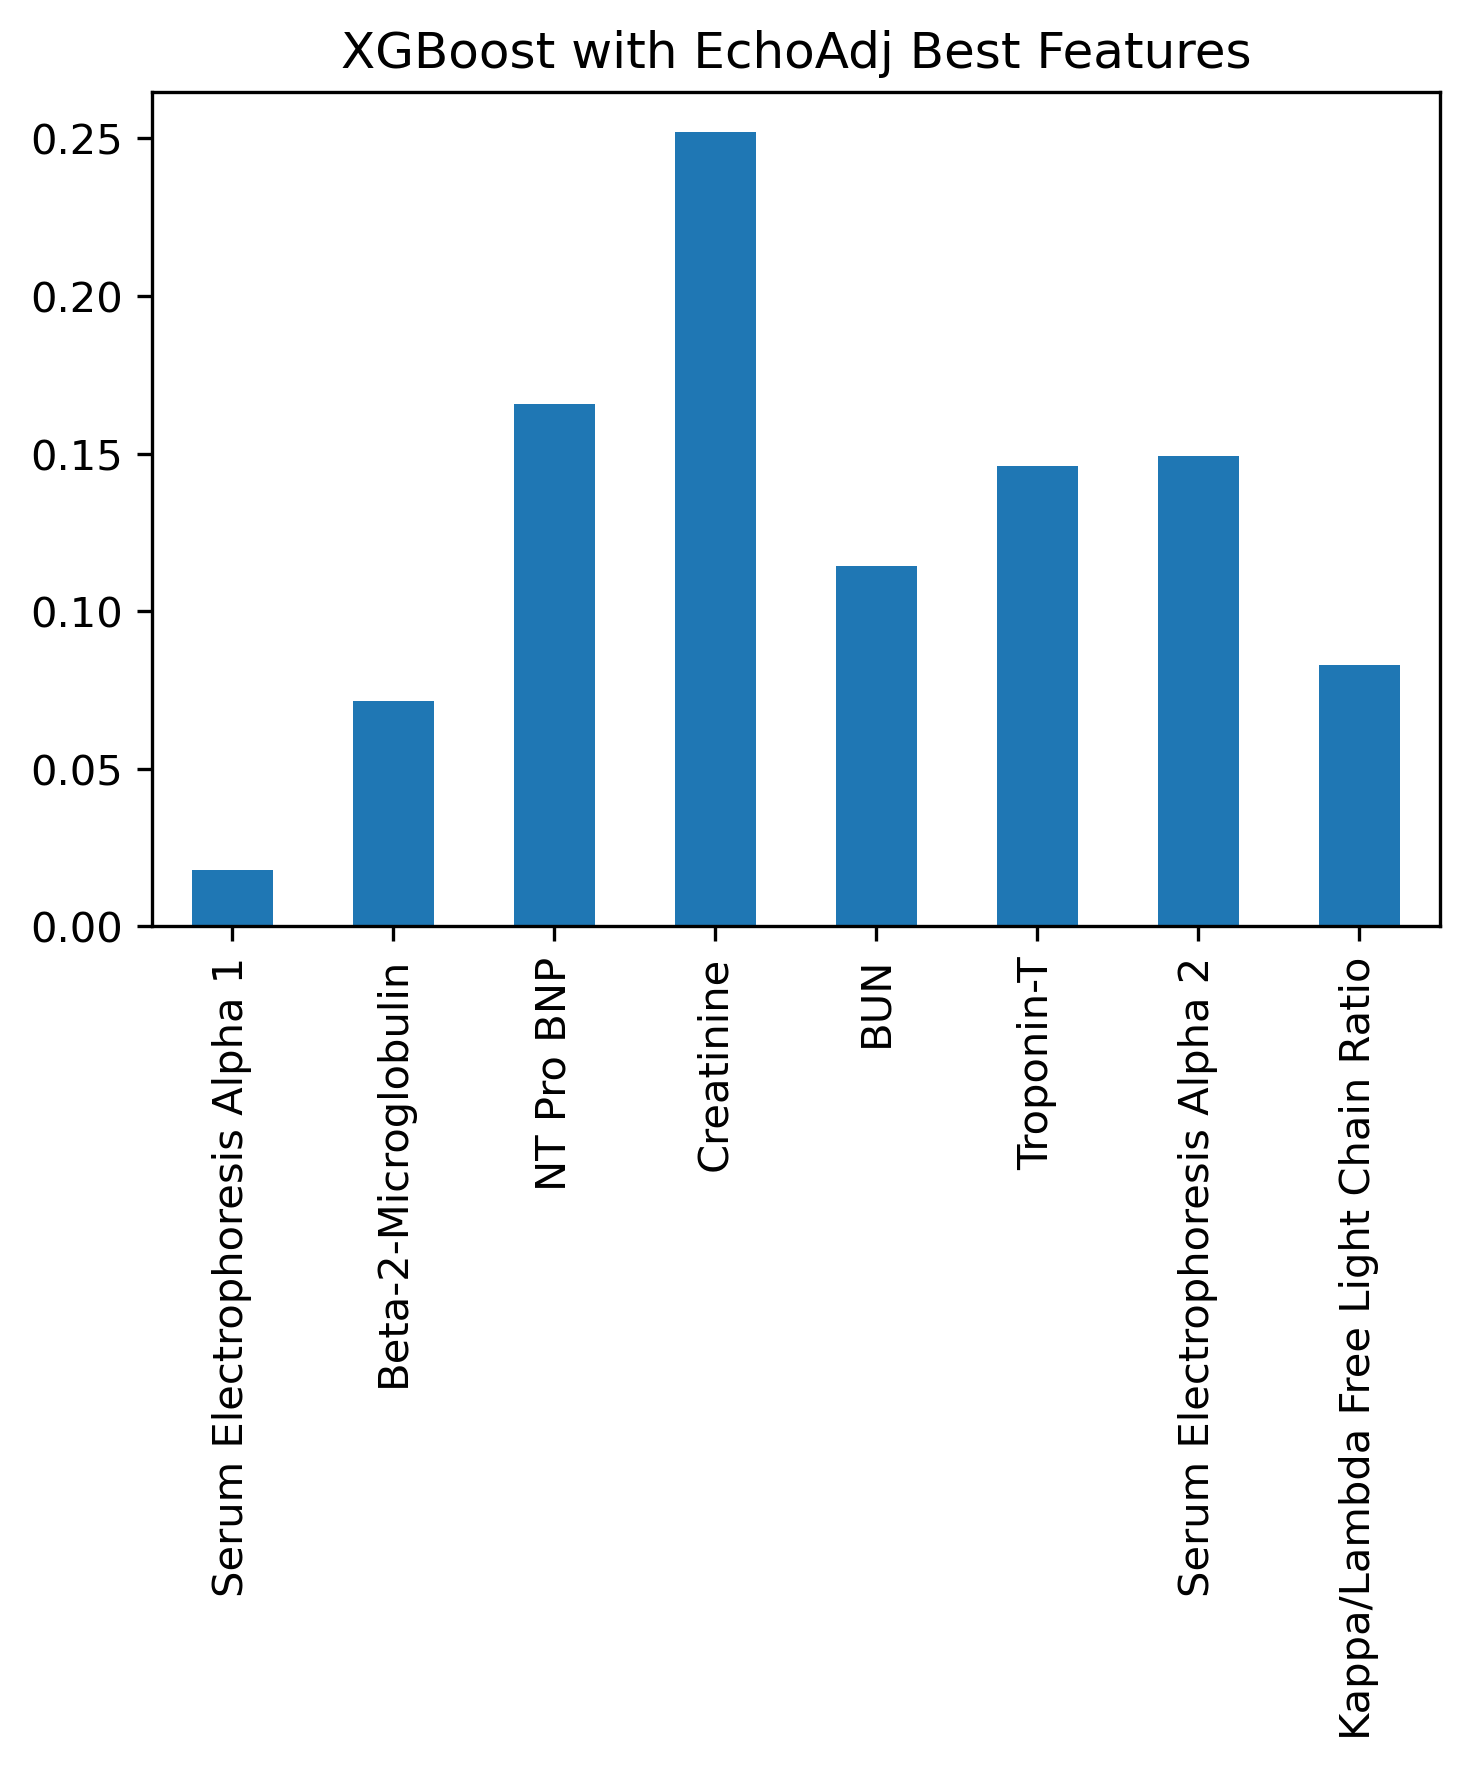

In [99]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_trim, y_train)
y_pred = xgb_clf.predict(X_test_trim)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))

importances_xgb = xgb_clf.feature_importances_
xgb_importances = pd.Series(importances_xgb, index= X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
fig, ax = plt.subplots(figsize = (5,6))
xgb_importances.plot.bar(ax=ax)
ax.set_title("XGBoost with EchoAdj Best Features")
fig.tight_layout()

In [100]:
paramsLGBM = {
    'objective': 'binary',
    'boosting_type':'gbdt',
    # 'num_leaves' : 45, 
    'learning_rate' : 0.05,
    'feature_fraction' : 0.90,
    'min_data_in_leaf': 1
}

lgb_clf = lgb.LGBMClassifier(**paramsLGBM)
lgb_clf.fit(X_train_trim, y_train)
y_pred = lgb_clf.predict(X_test_trim)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 17, number of negative: 18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 35, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485714 -> initscore=-0.057158
[LightGBM] [Info] Start training from score -0.057158
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



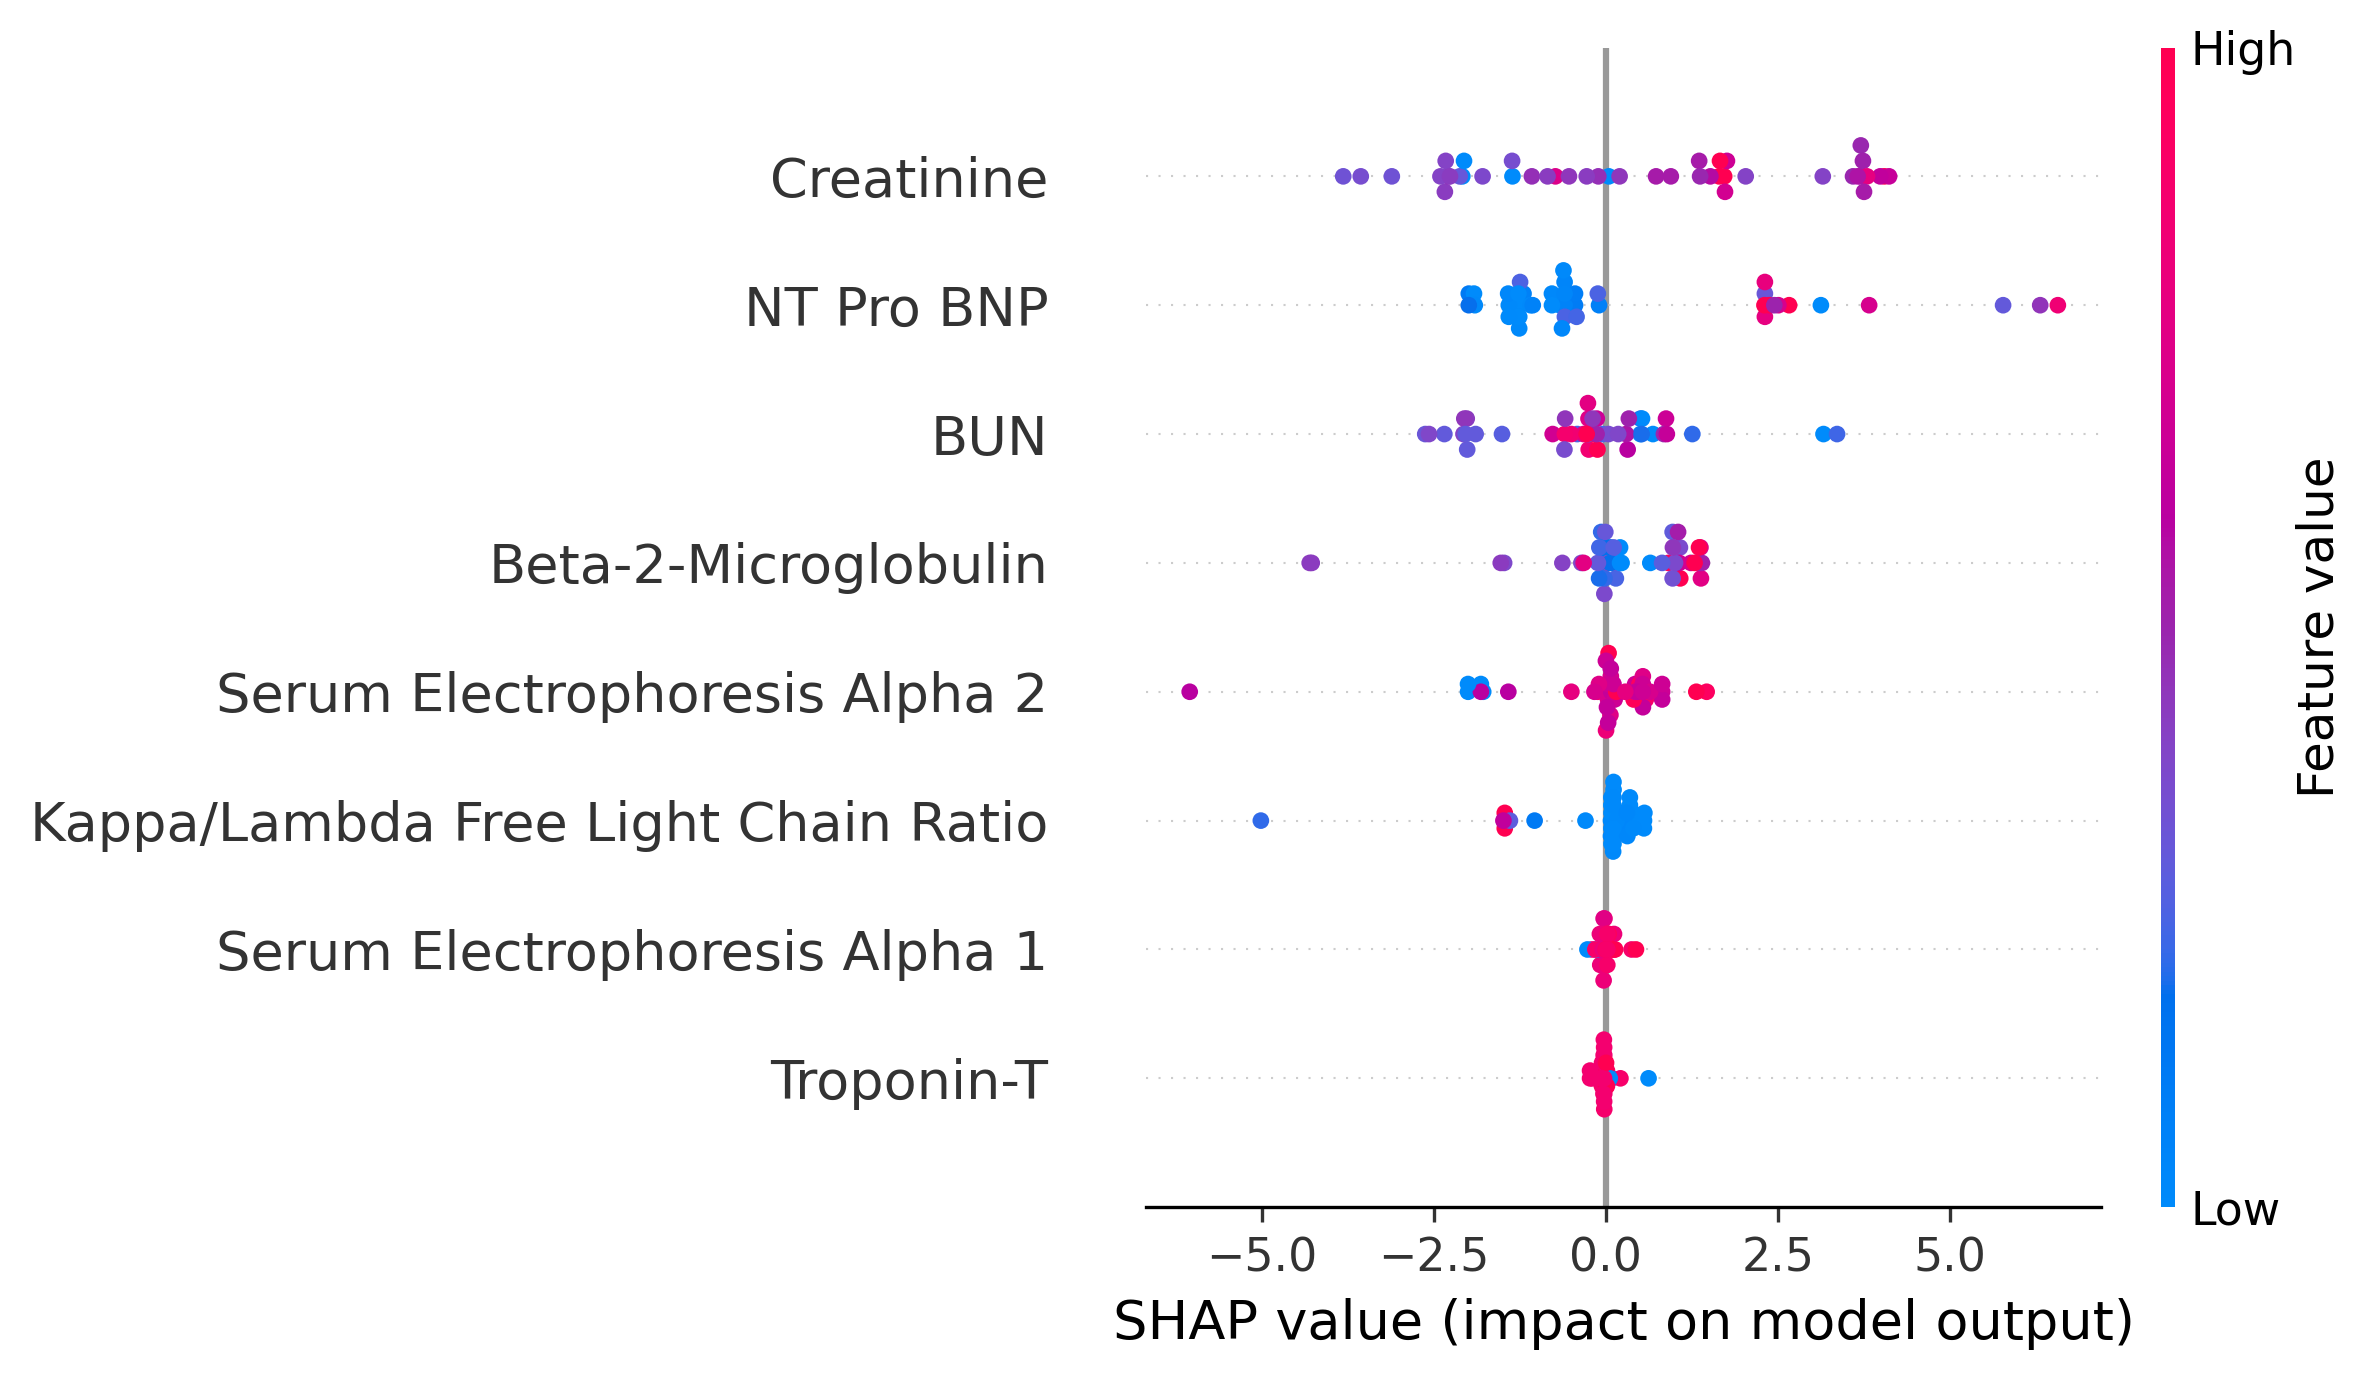

In [101]:
#borrowed from online source
#shap explainer
explainer = shap.TreeExplainer(lgb_clf)

#binary predictions
y_proba = lgb_clf.predict_proba(X_all_trim)[:,1]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_all_trim)

shap.summary_plot(shap_values, X_all_trim, feature_names = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)

# Show the plot
plt.show()

# correlation and heat maps for the best performing features of the SVM model

In [102]:
import seaborn as sns

In [103]:
dataTable

DeID  CA_status_yes  sex_female  dx_mgus  dx_mm  age  survival(mo)  \
0   B-02              1           0        1      0   48      9.466667   
1   C-03              1           1        0      1   59     17.000000   
2   E-01              1           0        1      0   50     71.300000   
3   E-02              1           0        1      0   64     20.466667   
4   F-03              1           0        0      1   61     52.000000   
5   G-02              1           1        0      1   36     30.000000   
6   I-01              1           1        0      1   55     33.000000   
7   I-03              1           0        1      0   67     10.033333   
8   J-02              1           1        0      1   68     26.000000   
9   K-02              1           1        0      1   68     27.000000   
10  M-02              1           0        1      0   70     24.800000   
11  N-03              1           0        0      1   69      8.000000   
12  O-03              1           1        0      1   71      4.233333   
13  Q-02              1           0        1      0   69     41.100000   
14  Q-03              1           1        0      1   41      3.466667   
15  T-01              1           0        0      0   71     14.433333   
16  V-02              1           0        0      1   79     50.000000   
17  W-01              1           0        0      1   57     42.000000   
18  X-01              1           0        1      0   80      5.300000   
19  X-02              1           0        1      0   63     38.233333   
20  Y-02              1           1        1      0   57     12.766667   
21  A-02              0           1        1      0   74      7.266667   
22  B-03              0           0        0      1   43     18.000000   
23  C-01              0           1        0      0   56     27.000000   
24  C-02              0           0        0      1   59     33.000000   
25  E-03              0           0        1      0   62     13.866667   
26  F-01              0           0        0      1   55    147.000000   
27  G-03              0           1        1      0   69     11.533333   
28  H-01              0           0        1      0   56     47.066667   
29  H-02              0           0        0      1   65     26.000000   
30  M-01              0           0        0      1   47     83.000000   
31  N-01              0           0        0      0   79     15.000000   
32  N-02              0           0        0      1   76     10.000000   
33  P-01              0           0        0      1   77     53.000000   
34  P-02              0           1        0      1   64     26.000000   
35  Q-01              0           1        1      0   57     48.800000   
36  R-01              0           0        0      1   68     21.000000   
37  R-03              0           1        1      0   62     12.966667   
38  S-02              0           1        0      1   69     20.000000   
39  T-02              0           0        0      1   60     19.000000   
40  V-01              0           1        0      1   66     43.000000   
41  W-02              0           0        1      0   72     13.500000   
42  Y-01              0           0        0      1   59     40.000000   
43  Z-01              0           1        0      0   72      2.000000   

    ChemoTx  HematologicTx  RadiationTx  ...  Serum Electrophoresis Alpha 1  \
0         0              0            0  ...                            0.4   
1         2              0            0  ...                            0.5   
2         0              0            0  ...                           -1.0   
3         0              0            0  ...                            0.3   
4         4              1            0  ...                            0.3   
5         0              0            0  ...                            0.6   
6         4              0            0  ...                            0.3   
7         0              0            0  

In [104]:
# create correlation matrix for all the input features
feature_correlation = dataTable.drop(columns= 'DeID').corr(method='spearman')
selected_features = list(X.columns[svm_set_ranks[selected_run].features])

#for CA positive
feature_correlation_CApositive = dataTable[dataTable[y_column_Classification] == 1].drop(columns = "DeID").corr(method='spearman')

#for CA negative
feature_correlation_CAnegative = dataTable[dataTable[y_column_Classification] == 0].drop(columns = "DeID").corr(method='spearman')

In [105]:
colormap = "RdBu"

ValueError: Invalid character / found in sheet title

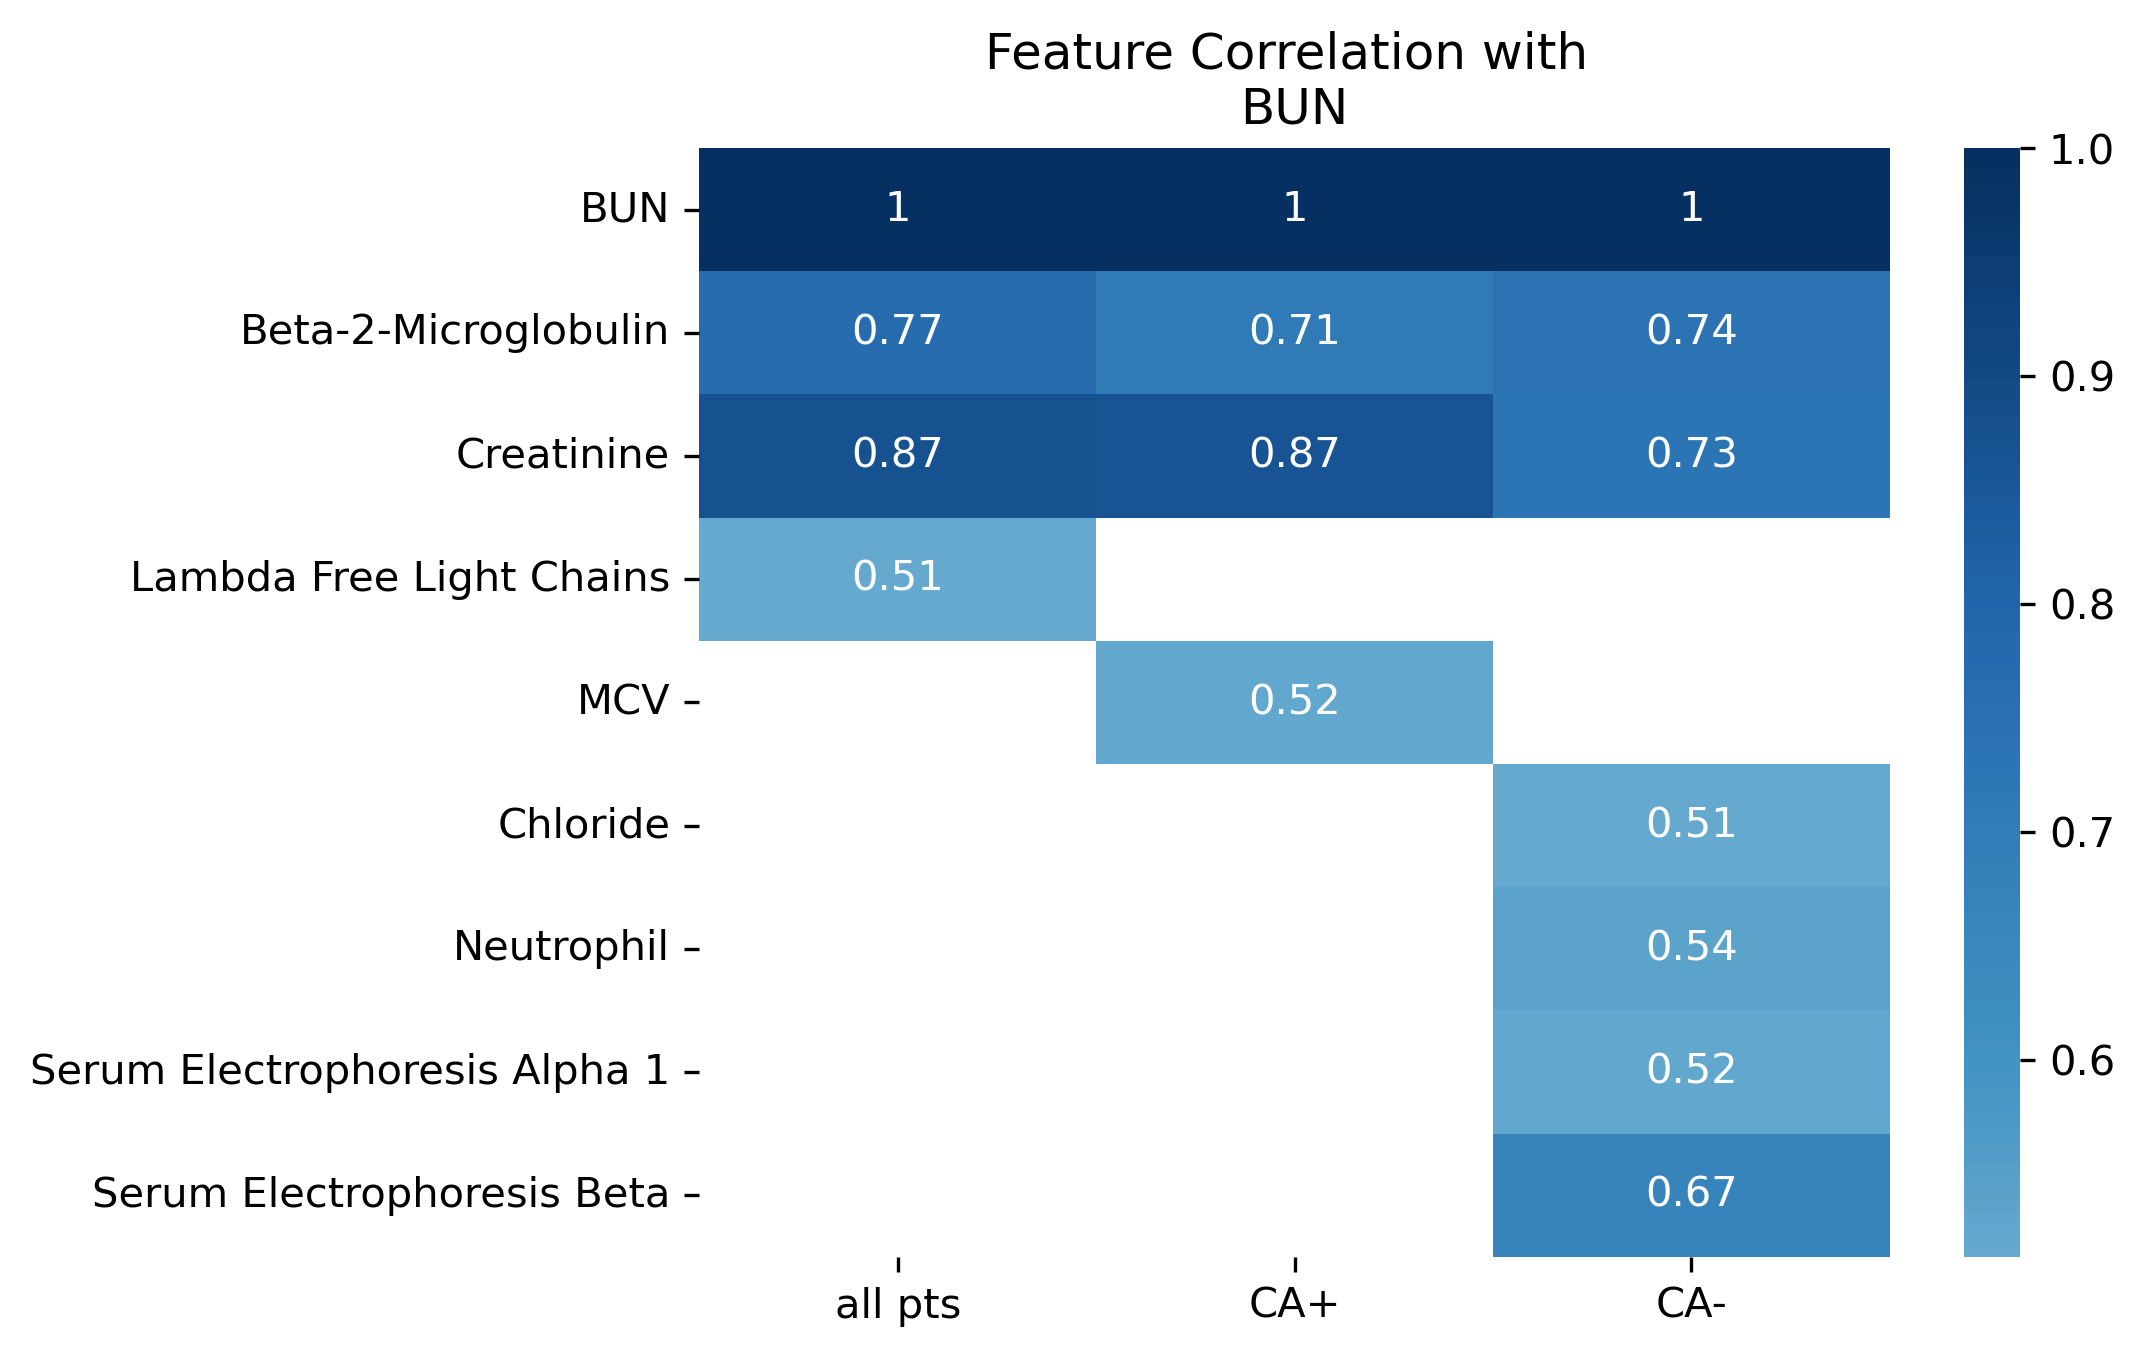

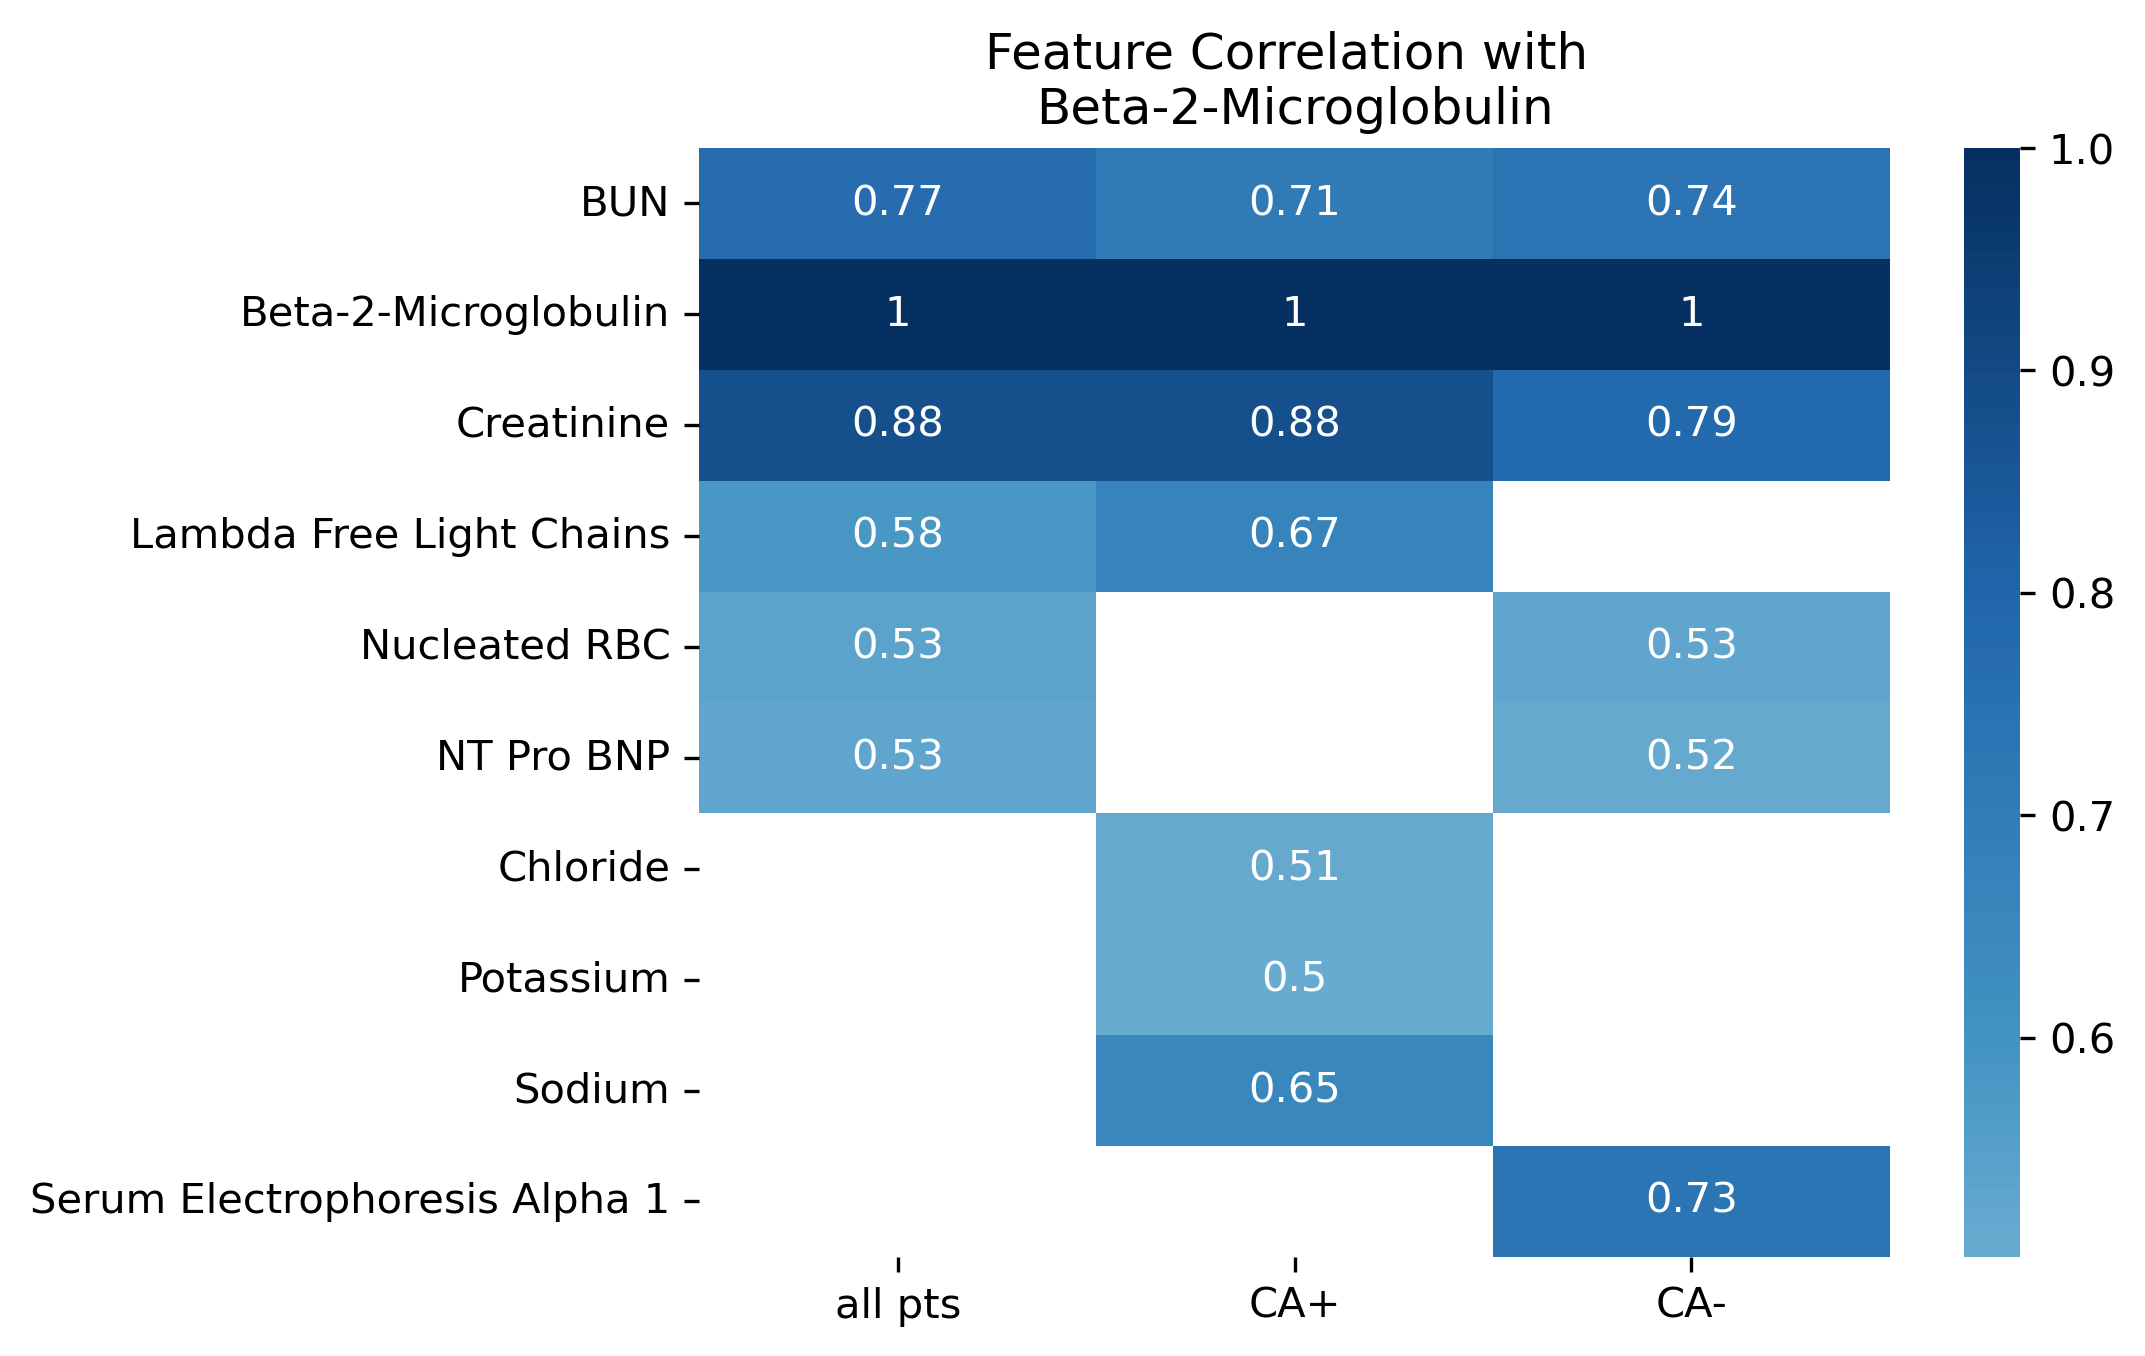

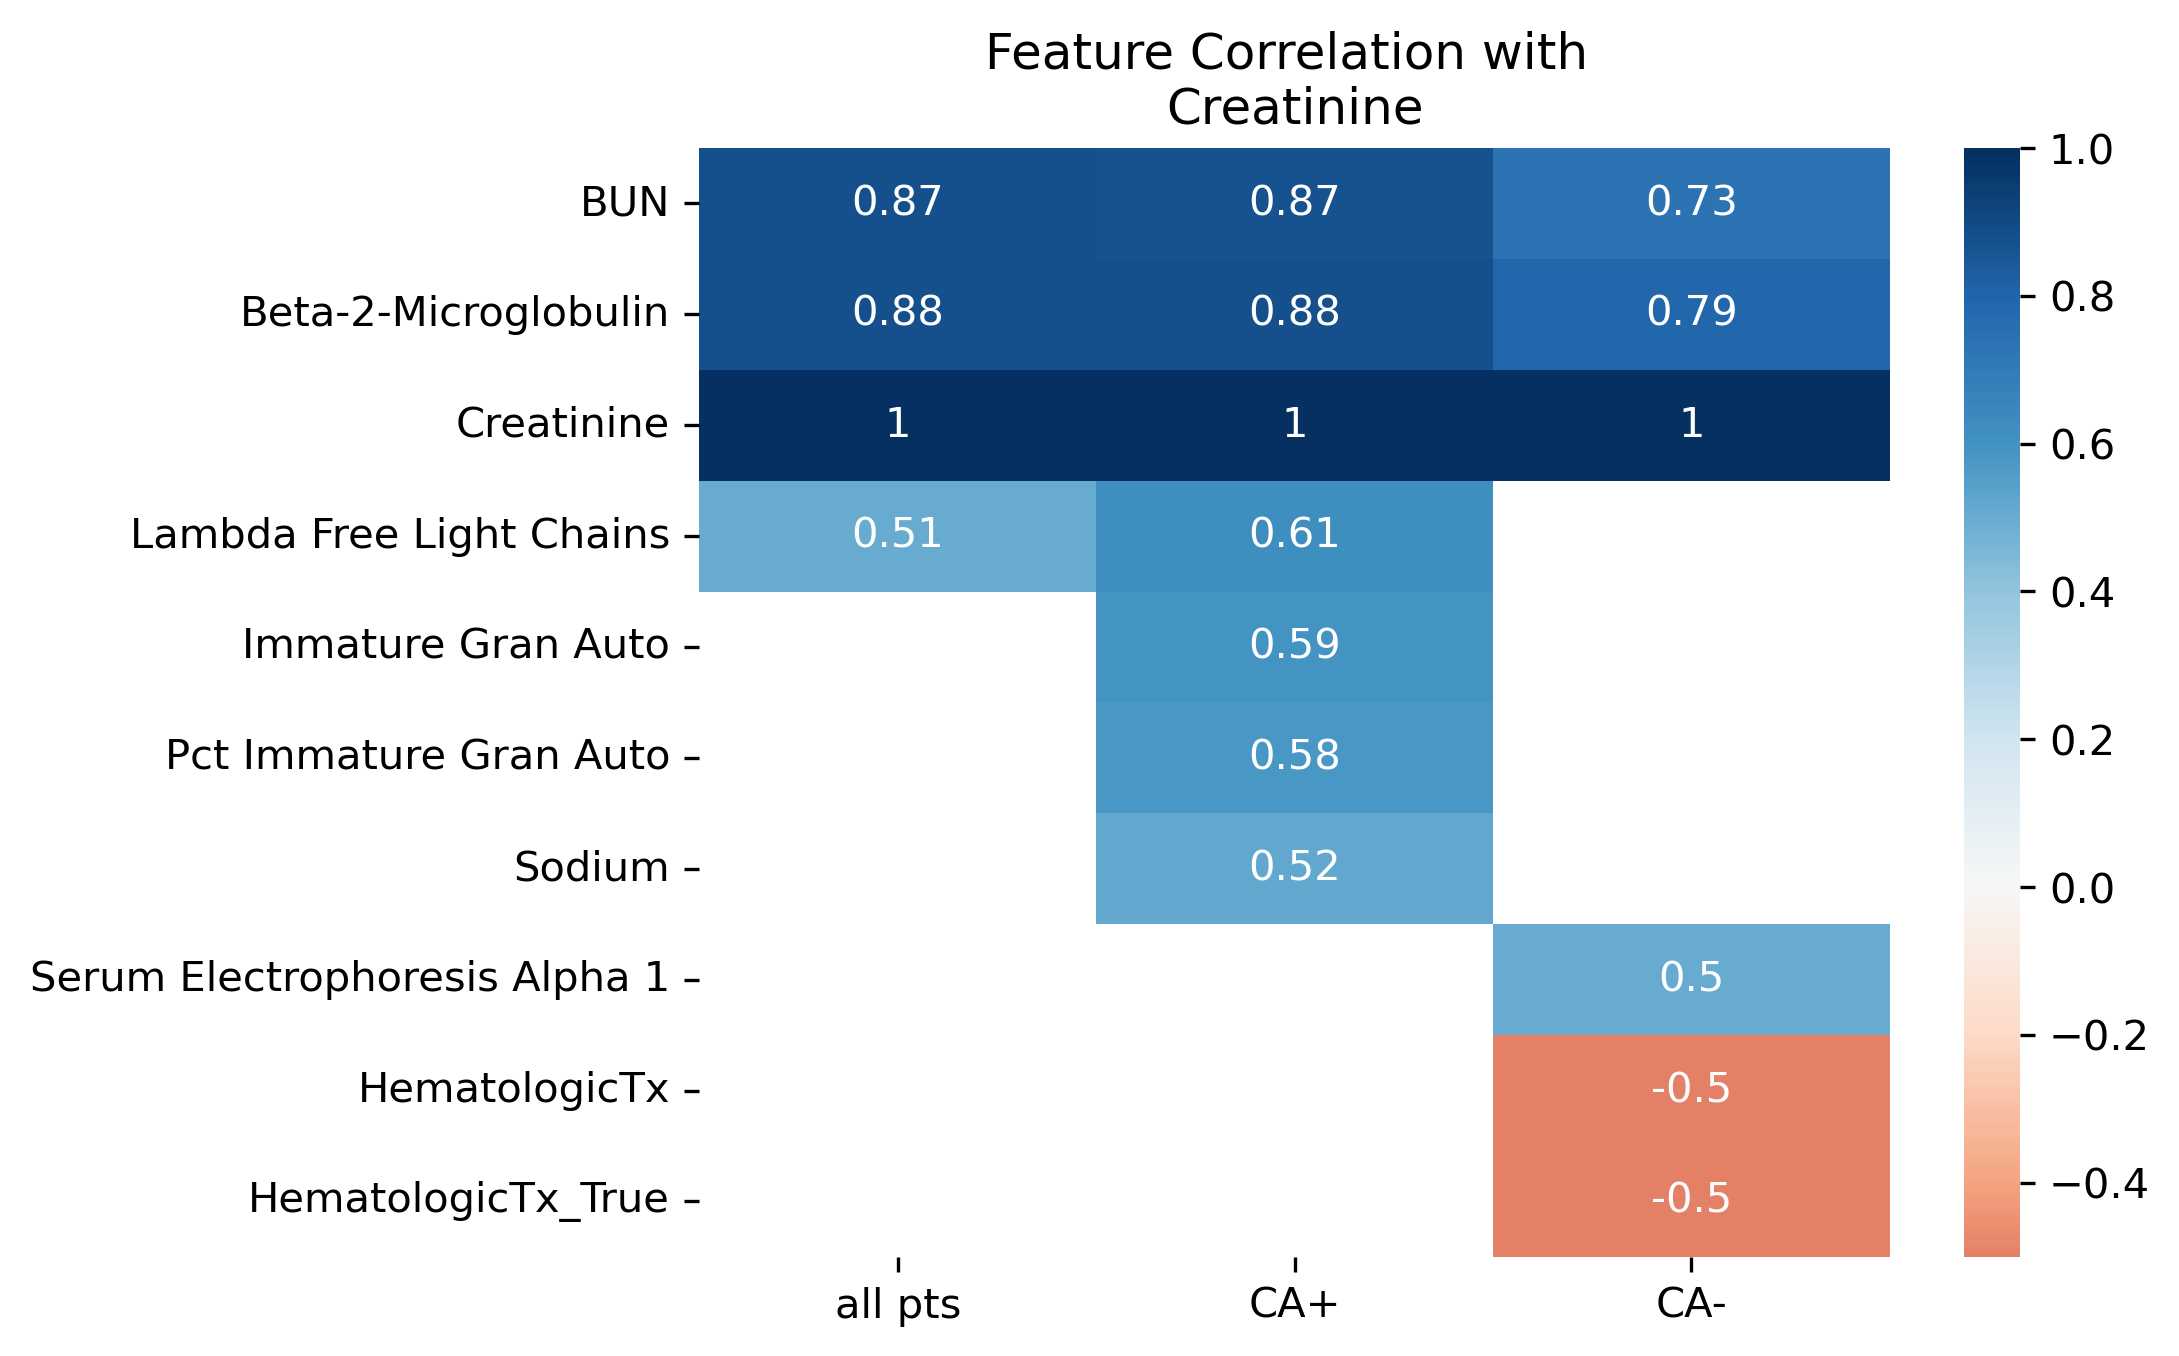

In [106]:
for feature_name in selected_features:
    feat_corr_sig_allpts = pd.concat([feature_correlation[feature_correlation[feature_name]>=0.5][feature_name], 
                                    feature_correlation[feature_correlation[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_CApos = pd.concat([feature_correlation_CApositive[feature_correlation_CApositive[feature_name]>=0.5][feature_name], 
                                     feature_correlation_CApositive[feature_correlation_CApositive[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_CAneg = pd.concat([feature_correlation_CAnegative[feature_correlation_CAnegative[feature_name]>=0.5][feature_name],
                                     feature_correlation_CAnegative[feature_correlation_CAnegative[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_concat = pd.concat([feat_corr_sig_allpts,feat_corr_sig_CApos,feat_corr_sig_CAneg], axis = 1)
    feat_corr_sig_concat.columns = ['all pts', 'CA+', 'CA-']

    outputToExcel(df_data = feat_corr_sig_concat, fileName_header= "featureCorr_", fileName_Common= "EchoAdj_", fileName_suffix= "250410_v2",
                       parent_dir= saving_dirrectory, folderName=makingFolder, sheetName=feature_name)

    fig, ax = plt.subplots()
    sns.heatmap(feat_corr_sig_concat, cmap= colormap, center = 0, annot = True, ax = ax)
    ax.set_title("Feature Correlation with \n"+ str(feature_name))

    figCommon = feature_name + "_heatmap_"
    # fig_file_out = ptFn.outputFiguresPath(fileName_header="", fileName_mid=figCommon, 
    #                         fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out)
    # fig.savefig(fig_file_out, bbox_inches = 'tight')
    # fig_file_out_jpg = ptFn.outputFiguresPath(fileName_header="", fileName_mid=figCommon, 
    #                 fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out, fileExtension= '.jpg')
    # fig.savefig(fig_file_out_jpg, bbox_inches = 'tight')